# Imports and Data Loading

**Experiment**: <br>
1. Inputs : Min, max, Qty, modal at time t-0 and modal_price from time t-0 to t-30
2. Output : modal_price from t+1 to t+5
3. Models : 
  1. LSTM.
  2. Bi-Dir LSTM.
  3. Stacked LSTM.
  4. Stacked Bi-Dir LSTM.
  5. Stacked LSTM and Bi-Dir LSTM combination. 
  6. Stacked Bi-Dir LSTM (Hyperparameter tuning).
  7. Stacked Bi Directional LSTM (Hyperparameter tuning) - Decreasing the number of hidden layers.
  8. Stacked Bi Directional LSTM (Hyperparameter tuning) - Increasing the number of nodes in hidden layers.
  9. Stacked Bi Directional LSTM (Hyperparameter tuning) - Increasing the number of hidden layers.

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 15,8
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Flatten, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D

In [2]:
from keras.layers import Attention, BatchNormalization, Dropout

In [3]:
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, adadelta

In [4]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
from google. colab import drive
drive.mount ('/content/drive/')

Mounted at /content/drive/


In [6]:
df_tomato = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Tomato_Kolar_2020_23.xlsx')
df_tomato.shape

(1163, 10)

In [7]:
df_tomato.head(5)

,state,district,market,commodity,variety,arrival_date,min_price,max_price,modal_price,quantity
0,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-01,400,1330,730,6224
1,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-02,400,1670,930,4439
2,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-03,400,1670,930,5983
3,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-04,330,1330,800,7830
4,Karnataka,Kolar,Kolar,Tomato,Tomato,2023-01-05,330,1200,530,6310


# EDA

In [8]:
df_tomato_2 = df_tomato.set_index('arrival_date',drop=True, verify_integrity=True)

In [9]:
df_tomato_2.sort_index(axis=1)

,commodity,district,market,max_price,min_price,modal_price,quantity,state,variety
arrival_date,,,,,,,,,
2023-01-01,Tomato,Kolar,Kolar,1330,400,730,6224,Karnataka,Tomato
2023-01-02,Tomato,Kolar,Kolar,1670,400,930,4439,Karnataka,Tomato
2023-01-03,Tomato,Kolar,Kolar,1670,400,930,5983,Karnataka,Tomato
2023-01-04,Tomato,Kolar,Kolar,1330,330,800,7830,Karnataka,Tomato
2023-01-05,Tomato,Kolar,Kolar,1200,330,530,6310,Karnataka,Tomato
...,...,...,...,...,...,...,...,...,...
2020-12-26,Tomato,Kolar,Kolar,1667,333,933,12250,Karnataka,Tomato
2020-12-27,Tomato,Kolar,Kolar,2000,667,1200,8530,Karnataka,Tomato
2020-12-28,Tomato,Kolar,Kolar,1733,400,1000,10794,Karnataka,Tomato


In [10]:
df_tomato_2 = df_tomato_2.drop(['state','district', 'market', 'commodity', 'variety'], axis=1)
df_tomato_2.head()

,min_price,max_price,modal_price,quantity
arrival_date,,,,
2023-01-01,400,1330,730,6224
2023-01-02,400,1670,930,4439
2023-01-03,400,1670,930,5983
2023-01-04,330,1330,800,7830
2023-01-05,330,1200,530,6310


In [11]:
df_tomato_2.isnull().sum()

min_price      0
max_price      0
modal_price    0
quantity       0
dtype: int64

In [12]:
cor_matrix = df_tomato_2.corr()

Text(0.5, 1.0, 'Heat map of correlation between features')

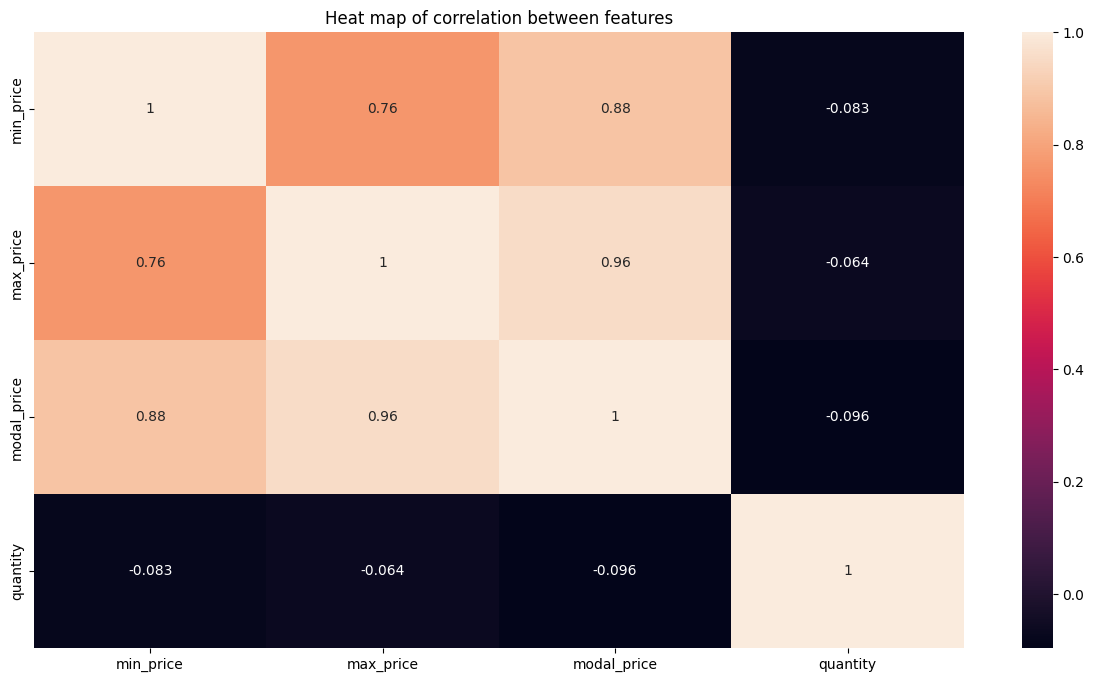

In [13]:
sns.heatmap(cor_matrix,annot=True)
plt.title("Heat map of correlation between features")

In [14]:
# Drop min_price and max_price because of hig auto-correlation 
# df_tomato_3 = df_tomato_2.drop(['min_price','max_price'], axis=1)
# df_tomato_3.head()

In [15]:
df_tomato_2.head()

,min_price,max_price,modal_price,quantity
arrival_date,,,,
2023-01-01,400,1330,730,6224
2023-01-02,400,1670,930,4439
2023-01-03,400,1670,930,5983
2023-01-04,330,1330,800,7830
2023-01-05,330,1200,530,6310


In [16]:
# Creating a new dataset and Sorting in ascending order of time series
df_tomato_3 = df_tomato_2[['quantity','min_price','max_price','modal_price']]
df_tomato_3.sort_index(ascending=True,inplace=True)
df_tomato_3.head()

,quantity,min_price,max_price,modal_price
arrival_date,,,,
2020-01-01,4144,333,1467,733
2020-01-02,4430,333,1733,986
2020-01-03,4532,400,2000,1047
2020-01-04,5578,333,2000,1033
2020-01-05,4960,333,2000,1033


# Preparing the dataset for training

### Creating Feature variable

In [17]:
# Function to create as many as features to represent the window size
def createWindow(winSize):
  df_temp = pd.DataFrame()
  for i in range(1,winSize+1):
    df_temp["feature_t"+str(i+1)] = df_tomato_3['modal_price'].shift(i)
  return df_temp

In [18]:
# Generating new features
df_newCols = createWindow(30)
df_newCols.head()

,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,feature_t8,feature_t9,feature_t10,feature_t11,...,feature_t22,feature_t23,feature_t24,feature_t25,feature_t26,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31
arrival_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,733.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,986.0,733.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,1047.0,986.0,733.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,1033.0,1047.0,986.0,733.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# joining with base dataframe
df_tomato_4 = df_tomato_3.join(df_newCols)
df_tomato_4.head()

,quantity,min_price,max_price,modal_price,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,...,feature_t22,feature_t23,feature_t24,feature_t25,feature_t26,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31
arrival_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,4144,333,1467,733,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,4430,333,1733,986,733.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,4532,400,2000,1047,986.0,733.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,5578,333,2000,1033,1047.0,986.0,733.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,4960,333,2000,1033,1033.0,1047.0,986.0,733.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Replacing null values with 0, thus created window of 30 days as each input.
for val in df_tomato_4.columns:
  df_tomato_4[val].fillna(0, inplace=True)
df_tomato_4.head()

,quantity,min_price,max_price,modal_price,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,...,feature_t22,feature_t23,feature_t24,feature_t25,feature_t26,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31
arrival_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,4144,333,1467,733,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,4430,333,1733,986,733.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,4532,400,2000,1047,986.0,733.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,5578,333,2000,1033,1047.0,986.0,733.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,4960,333,2000,1033,1033.0,1047.0,986.0,733.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating Target Variable

In [21]:
# Creating target Variables
def createTargets(winSize):
  df_temp = pd.DataFrame()
  for i in range(1,winSize+1):
    df_temp["target_t"+str(i)] = df_tomato_3['modal_price'].shift(-i)
  return df_temp

In [22]:
# Generating target columns
df_newTargetCols = createTargets(5)
df_newTargetCols.head()

,target_t1,target_t2,target_t3,target_t4,target_t5
arrival_date,,,,,
2020-01-01,986.0,1047.0,1033.0,1033.0,1046.0
2020-01-02,1047.0,1033.0,1033.0,1046.0,1153.0
2020-01-03,1033.0,1033.0,1046.0,1153.0,933.0
2020-01-04,1033.0,1046.0,1153.0,933.0,1133.0
2020-01-05,1046.0,1153.0,933.0,1133.0,933.0


In [23]:
# joining with base dataframe
df_tomato_4 = df_tomato_4.join(df_newTargetCols)
df_tomato_4.head()

,quantity,min_price,max_price,modal_price,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,...,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31,target_t1,target_t2,target_t3,target_t4,target_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,4144,333,1467,733,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,986.0,1047.0,1033.0,1033.0,1046.0
2020-01-02,4430,333,1733,986,733.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1047.0,1033.0,1033.0,1046.0,1153.0
2020-01-03,4532,400,2000,1047,986.0,733.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1033.0,1033.0,1046.0,1153.0,933.0
2020-01-04,5578,333,2000,1033,1047.0,986.0,733.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1033.0,1046.0,1153.0,933.0,1133.0
2020-01-05,4960,333,2000,1033,1033.0,1047.0,986.0,733.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1046.0,1153.0,933.0,1133.0,933.0


In [24]:
# Drop all the null values
df_tomato_4.dropna(inplace=True)
df_tomato_4

,quantity,min_price,max_price,modal_price,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,...,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31,target_t1,target_t2,target_t3,target_t4,target_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,4144,333,1467,733,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,986.0,1047.0,1033.0,1033.0,1046.0
2020-01-02,4430,333,1733,986,733.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1047.0,1033.0,1033.0,1046.0,1153.0
2020-01-03,4532,400,2000,1047,986.0,733.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1033.0,1033.0,1046.0,1153.0,933.0
2020-01-04,5578,333,2000,1033,1047.0,986.0,733.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1033.0,1046.0,1153.0,933.0,1133.0
2020-01-05,4960,333,2000,1033,1033.0,1047.0,986.0,733.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1046.0,1153.0,933.0,1133.0,933.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,2874,400,1800,1000,1200.0,1130.0,1000.0,1000.0,1000.0,1200.0,...,1070.0,1000.0,930.0,1070.0,1000.0,1270.0,1200.0,1000.0,930.0,870.0
2023-03-10,3506,530,2000,1270,1000.0,1200.0,1130.0,1000.0,1000.0,1000.0,...,1200.0,1070.0,1000.0,930.0,1070.0,1200.0,1000.0,930.0,870.0,930.0
2023-03-11,3698,400,1870,1200,1270.0,1000.0,1200.0,1130.0,1000.0,1000.0,...,1200.0,1200.0,1070.0,1000.0,930.0,1000.0,930.0,870.0,930.0,730.0


### Scaling

In [25]:
# Preprocessing the dataset
# Extract the values from the DataFrame
data_to_scale = df_tomato_4.copy()
# Initialize the scaler
scaler = MinMaxScaler()
# Fit the scaler to the data
scaler.fit(data_to_scale)
# Transform the data
scaled_data = scaler.transform(data_to_scale)
# convert the scaled_data array back to a DataFrame with Timestamp index
scaled_data_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns, index=data_to_scale.index)
# combine the scaled data with the Timestamp index column
# scaled_data_df = pd.concat([df_tomato_3.index.to_frame(), scaled_data_df], axis=1)
scaled_data_df.head()

,quantity,min_price,max_price,modal_price,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,...,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31,target_t1,target_t2,target_t3,target_t4,target_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.076304,0.068107,0.129021,0.091897,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.135517,0.146034,0.143621,0.143621,0.145862
2020-01-02,0.083274,0.068107,0.161185,0.135517,0.122167,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.146034,0.143621,0.143621,0.145862,0.164310
2020-01-03,0.085760,0.085133,0.193470,0.146034,0.164333,0.122167,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.143621,0.143621,0.145862,0.164310,0.126379
2020-01-04,0.111252,0.068107,0.193470,0.143621,0.174500,0.164333,0.122167,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.143621,0.145862,0.164310,0.126379,0.160862
2020-01-05,0.096191,0.068107,0.193470,0.143621,0.172167,0.174500,0.164333,0.122167,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.145862,0.164310,0.126379,0.160862,0.126379


### Train Test Split

In [26]:
# Split the data into train and test sets
train_size = int(len(scaled_data_df) * 0.8)
train_data = scaled_data_df[:train_size]
test_data = scaled_data_df[train_size:]

In [27]:
# Splitting target and feature variables
train_X = train_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)
train_y = train_data[['target_t1','target_t2','target_t3','target_t4','target_t5']]

test_X = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)
test_y = test_data[['target_t1','target_t2','target_t3','target_t4','target_t5']]

In [28]:
# Converting Dataframe to 3D array
vec_train_X = train_X.values
vec_train_y = train_y.values

vec_test_X = test_X.values
vec_test_y = test_y.values

In [29]:
# reshape input to be 3D [samples, look_back, features]
# samples -> are the number of rows in your data set
# look_back -> number of times to feed in the model or LSTM
# features -> number of columns of each sample

vec_train_X = vec_train_X.reshape((int(train_X.shape[0]), 17, 2))
vec_test_X = vec_test_X.reshape((int(test_X.shape[0]), 17, 2))

In [30]:
# Verifying the shape of train and test
print(vec_train_X.shape, vec_train_y.shape, vec_test_X.shape, vec_test_y.shape)

(926, 17, 2) (926, 5) (232, 17, 2) (232, 5)


# Model 1 - Simple LSTM

## Model building

In [31]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model.add(Dense(vec_train_y.shape[1]))
model.compile(loss='mae', optimizer='adam')

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10600     
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 10,855
Trainable params: 10,855
Non-trainable params: 0
_________________________________________________________________


In [33]:
# fit network
history = model.fit(vec_train_X, vec_train_y, epochs=50, batch_size=72, 
                    validation_data=(vec_test_X, vec_test_y), verbose=2,
                    shuffle=False)

Epoch 1/50
13/13 - 4s - loss: 0.1031 - val_loss: 0.0498 - 4s/epoch - 279ms/step
Epoch 2/50
13/13 - 0s - loss: 0.0808 - val_loss: 0.0497 - 177ms/epoch - 14ms/step
Epoch 3/50
13/13 - 0s - loss: 0.0755 - val_loss: 0.0509 - 159ms/epoch - 12ms/step
Epoch 4/50
13/13 - 0s - loss: 0.0722 - val_loss: 0.0484 - 167ms/epoch - 13ms/step
Epoch 5/50
13/13 - 0s - loss: 0.0675 - val_loss: 0.0483 - 186ms/epoch - 14ms/step
Epoch 6/50
13/13 - 0s - loss: 0.0642 - val_loss: 0.0457 - 178ms/epoch - 14ms/step
Epoch 7/50
13/13 - 0s - loss: 0.0588 - val_loss: 0.0435 - 167ms/epoch - 13ms/step
Epoch 8/50
13/13 - 0s - loss: 0.0535 - val_loss: 0.0407 - 159ms/epoch - 12ms/step
Epoch 9/50
13/13 - 0s - loss: 0.0503 - val_loss: 0.0423 - 164ms/epoch - 13ms/step
Epoch 10/50
13/13 - 0s - loss: 0.0658 - val_loss: 0.0415 - 164ms/epoch - 13ms/step
Epoch 11/50
13/13 - 0s - loss: 0.0541 - val_loss: 0.0467 - 166ms/epoch - 13ms/step
Epoch 12/50
13/13 - 0s - loss: 0.0536 - val_loss: 0.0394 - 181ms/epoch - 14ms/step
Epoch 13/50
13/

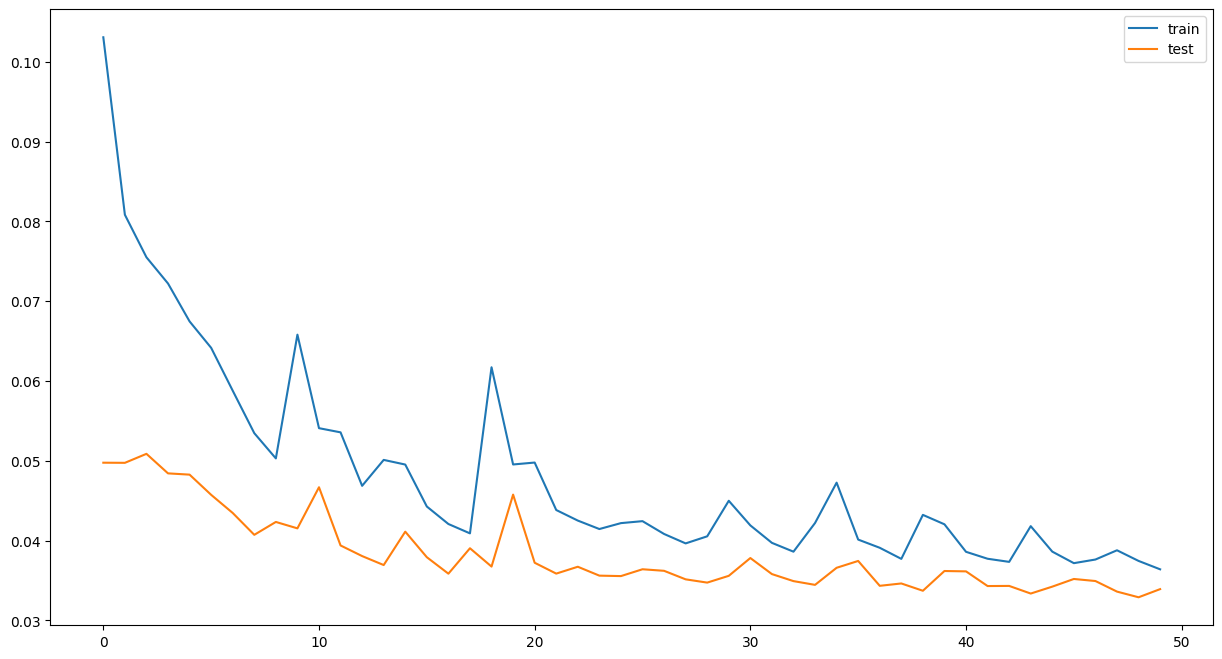

In [34]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [35]:
# make a prediction
pred_y = model.predict(vec_test_X)

8/8 [==============================] - 0s 4ms/step


In [36]:
pred_y[:5]

array([[0.05680906, 0.06066447, 0.06300145, 0.04754923, 0.05337822],
       [0.06027874, 0.06406716, 0.06758384, 0.05385539, 0.06085384],
       [0.06289323, 0.06726911, 0.06950074, 0.05642573, 0.06282217],
       [0.06990951, 0.07279041, 0.0749759 , 0.06112589, 0.06717338],
       [0.07134533, 0.07313166, 0.07496122, 0.0645141 , 0.0698656 ]],
      dtype=float32)

In [37]:
pred_y.shape

(232, 5)

## Resacling Prediction

In [38]:
data_pred = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)

In [39]:
for i in range(0,5):
  data_pred['prediction_t'+str(i)] = pred_y[:,i]

In [40]:
data_pred

,quantity,min_price,max_price,modal_price,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,...,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31,prediction_t0,prediction_t1,prediction_t2,prediction_t3,prediction_t4
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-07-23,0.875515,0.067344,0.072551,0.081034,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,...,0.321667,0.388333,0.421667,0.388333,0.445000,0.056809,0.060664,0.063001,0.047549,0.053378
2022-07-24,0.864548,0.067344,0.081016,0.091379,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,...,0.311667,0.321667,0.388333,0.421667,0.388333,0.060279,0.064067,0.067584,0.053855,0.060854
2022-07-25,0.804913,0.067344,0.105200,0.081034,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,...,0.245000,0.311667,0.321667,0.388333,0.421667,0.062893,0.067269,0.069501,0.056426,0.062822
2022-07-26,0.854483,0.067344,0.105200,0.091379,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,...,0.145000,0.245000,0.311667,0.321667,0.388333,0.069910,0.072790,0.074976,0.061126,0.067173
2022-07-27,0.798577,0.059720,0.096735,0.091379,0.121667,0.111667,0.121667,0.111667,0.111667,0.121667,...,0.121667,0.145000,0.245000,0.311667,0.321667,0.071345,0.073132,0.074961,0.064514,0.069866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,0.085133,0.169287,0.137931,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,...,0.178333,0.166667,0.155000,0.178333,0.166667,0.147678,0.147944,0.144017,0.143977,0.146588
2023-03-10,0.060756,0.118170,0.193470,0.184483,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,...,0.200000,0.178333,0.166667,0.155000,0.178333,0.161501,0.161074,0.157139,0.155733,0.156263
2023-03-11,0.065435,0.085133,0.177751,0.172414,0.211667,0.166667,0.200000,0.188333,0.166667,0.166667,...,0.200000,0.200000,0.178333,0.166667,0.155000,0.148041,0.147890,0.144843,0.143861,0.146739


In [41]:
inv_pred_y = scaler.inverse_transform(data_pred)
inv_pred_y = inv_pred_y[:,-5:]

In [42]:
# Display Predicted values
inv_pred_y[:5,]

array([[529.4925496 , 551.85391158, 565.40838927, 475.78555048,
        509.59370136],
       [549.61671233, 571.58954293, 591.98629558, 512.36125827,
        552.95226574],
       [564.78075832, 590.1608333 , 603.10431719, 527.26924345,
        564.36858922],
       [605.47513217, 622.18440175, 634.86022204, 554.53018025,
        589.60562795],
       [613.80290985, 624.16361719, 634.77509171, 574.1817832 ,
        605.22047579]])

## Rescaling Actuals

In [43]:
data_actual= test_data

In [44]:
inv_test_y = scaler.inverse_transform(data_actual)
inv_test_y = inv_test_y[:,-5:]

In [45]:
# Display Actual target values
inv_test_y[:5,]

array([[730., 670., 730., 730., 470.],
       [670., 730., 730., 470., 530.],
       [730., 730., 470., 530., 600.],
       [730., 470., 530., 600., 670.],
       [470., 530., 600., 670., 670.]])

## Comapring Actuals vs Predicted

In [46]:
pred_df = test_data[['quantity']]

In [47]:
for i in range(0,5):
  pred_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred_df['prediction_t'+str(i+1)] = inv_pred_y[:,i]

In [48]:
pred_df

,quantity,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,,
2022-07-23,0.875515,730.0,529.492550,670.0,551.853912,730.0,565.408389,730.0,475.785550,470.0,509.593701
2022-07-24,0.864548,670.0,549.616712,730.0,571.589543,730.0,591.986296,470.0,512.361258,530.0,552.952266
2022-07-25,0.804913,730.0,564.780758,730.0,590.160833,470.0,603.104317,530.0,527.269243,600.0,564.368589
2022-07-26,0.854483,730.0,605.475132,470.0,622.184402,530.0,634.860222,600.0,554.530180,670.0,589.605628
2022-07-27,0.798577,470.0,613.802910,530.0,624.163617,600.0,634.775092,670.0,574.181783,670.0,605.220476
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,1270.0,1056.531551,1200.0,1058.075133,1000.0,1035.301256,930.0,1035.067126,870.0,1050.209695
2023-03-10,0.060756,1200.0,1136.708078,1000.0,1134.227803,930.0,1111.407861,870.0,1103.253067,930.0,1106.324327
2023-03-11,0.065435,1000.0,1058.637685,930.0,1057.764602,870.0,1040.089902,930.0,1034.394553,730.0,1051.088309


In [49]:
# Calculate the error
#print("Results of sklearn.metrics:")
#for i in range(1,6):
#  print("MAPE_",i,": %.3f" % mean_absolute_percentage_error(inv_test_y[:,-1*i],inv_pred_y[:,-1*i]))

# Output without the drop NA in features generation

In [50]:
# Calculate the error
error1 = pd.Series()
for i in range(0,5):
  error1['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred_y[:,i])
print("Results of sklearn.metrics:")
print(error1)

Results of sklearn.metrics:
MAPE_1    0.158445
MAPE_2    0.174372
MAPE_3    0.185455
MAPE_4    0.204731
MAPE_5    0.208217
dtype: float64


In [51]:
model_comparision = pd.DataFrame(data = error1)
model_comparision.rename(columns={0:'LSTM'}, inplace= True)
model_comparision

,LSTM
MAPE_1,0.158445
MAPE_2,0.174372
MAPE_3,0.185455
MAPE_4,0.204731
MAPE_5,0.208217


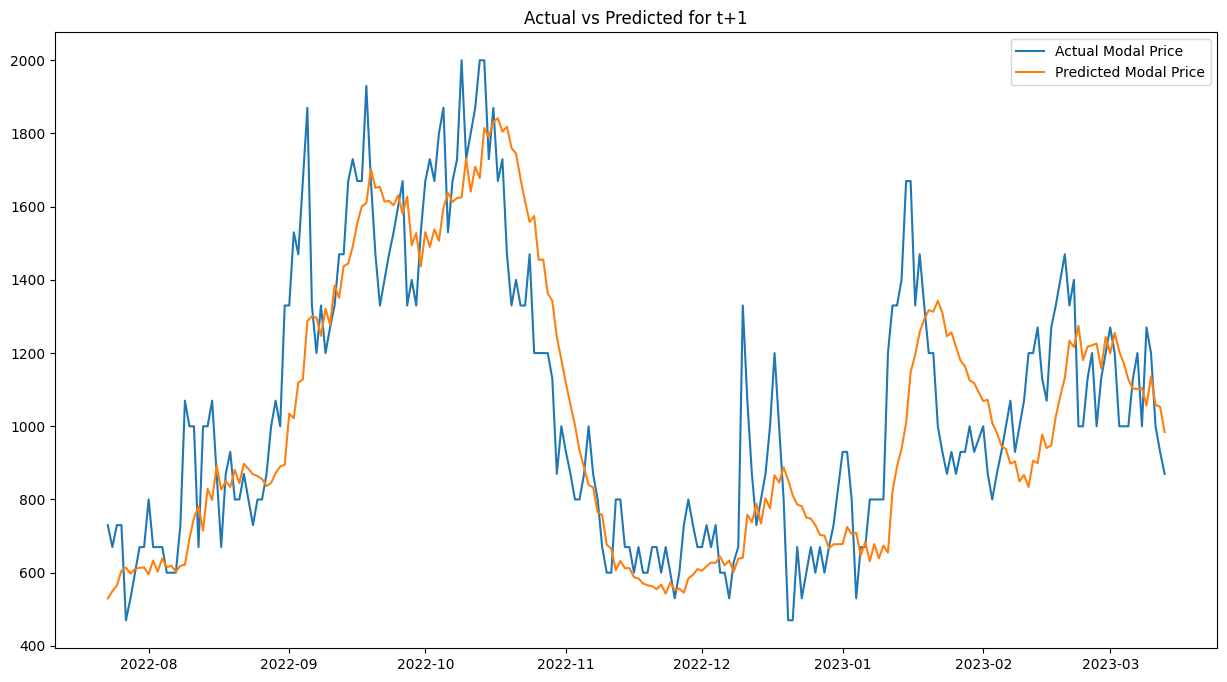

In [52]:
plt.plot(pred_df['modal_price_actual_t1'], label='Actual Modal Price')
plt.plot(pred_df['prediction_t1'],  label='Predicted Modal Price')
plt.legend()
plt.title('Actual vs Predicted for t+1')
plt.show()

# Model 2 - Stacked LSTM

## Model Building

In [53]:
# Build the Stacked LSTM model
model_stacked = Sequential()
model_stacked.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_stacked.add(LSTM(50, activation='relu'))
model_stacked.add(Dense(vec_train_y.shape[1]))
model_stacked.compile(optimizer='adam', loss='mae')

In [54]:
# fit network
history_2 = model_stacked.fit(vec_train_X, vec_train_y, epochs=50, batch_size=72, 
                              validation_data=(vec_test_X, vec_test_y), verbose=2,
                              shuffle=False)

Epoch 1/50
13/13 - 4s - loss: 0.1260 - val_loss: 0.0520 - 4s/epoch - 333ms/step
Epoch 2/50
13/13 - 1s - loss: 0.0854 - val_loss: 0.0512 - 530ms/epoch - 41ms/step
Epoch 3/50
13/13 - 1s - loss: 0.0753 - val_loss: 0.0450 - 545ms/epoch - 42ms/step
Epoch 4/50
13/13 - 0s - loss: 0.0710 - val_loss: 0.0459 - 374ms/epoch - 29ms/step
Epoch 5/50
13/13 - 0s - loss: 0.0674 - val_loss: 0.0490 - 304ms/epoch - 23ms/step
Epoch 6/50
13/13 - 0s - loss: 0.0676 - val_loss: 0.0435 - 316ms/epoch - 24ms/step
Epoch 7/50
13/13 - 1s - loss: 0.0625 - val_loss: 0.0473 - 597ms/epoch - 46ms/step
Epoch 8/50
13/13 - 1s - loss: 0.0630 - val_loss: 0.0435 - 597ms/epoch - 46ms/step
Epoch 9/50
13/13 - 1s - loss: 0.0596 - val_loss: 0.0434 - 676ms/epoch - 52ms/step
Epoch 10/50
13/13 - 1s - loss: 0.0577 - val_loss: 0.0442 - 589ms/epoch - 45ms/step
Epoch 11/50
13/13 - 1s - loss: 0.0569 - val_loss: 0.0410 - 591ms/epoch - 45ms/step
Epoch 12/50
13/13 - 1s - loss: 0.0536 - val_loss: 0.0435 - 550ms/epoch - 42ms/step
Epoch 13/50
13/

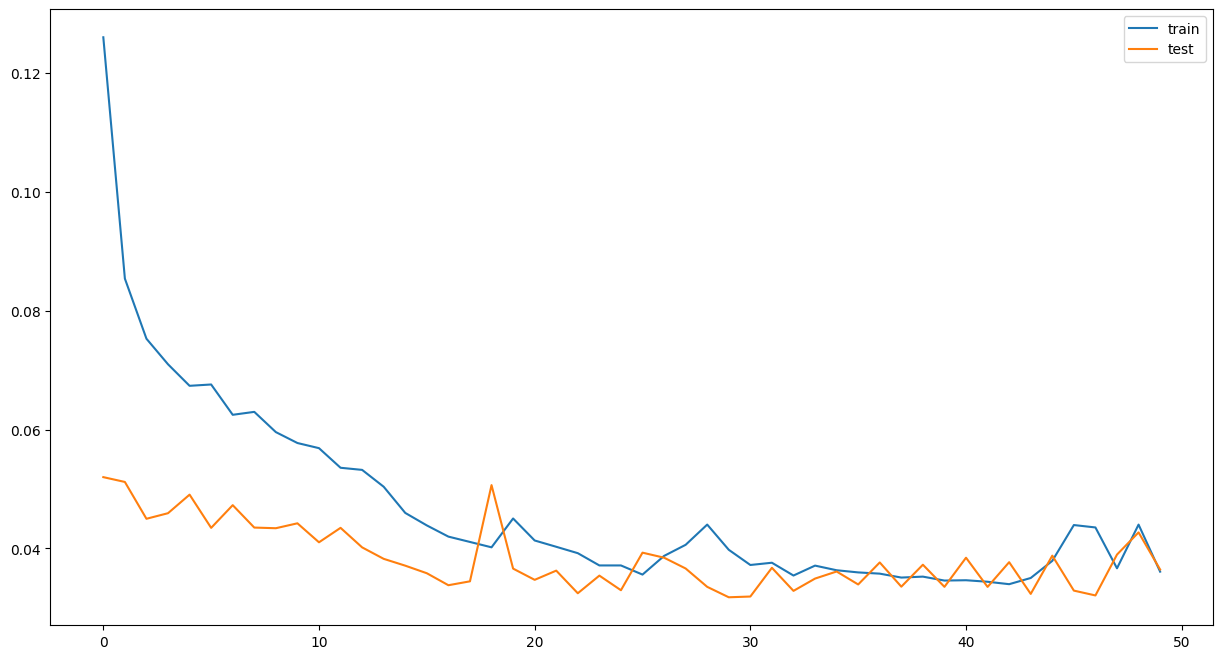

In [55]:
# plot history
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [56]:
# make a prediction
pred2_y = model_stacked.predict(vec_test_X)

8/8 [==============================] - 0s 7ms/step


In [57]:
pred2_y[:5]

array([[0.07637454, 0.0711523 , 0.07049393, 0.06829917, 0.06218066],
       [0.07654078, 0.07344449, 0.07209869, 0.06926052, 0.06506716],
       [0.07738772, 0.07570177, 0.07389386, 0.07037301, 0.06837368],
       [0.07532529, 0.07528199, 0.07263118, 0.06970017, 0.0681101 ],
       [0.07451259, 0.07553123, 0.07249672, 0.06951814, 0.06898421]],
      dtype=float32)

In [58]:
pred2_y.shape

(232, 5)

## Rescaling Prediction

In [59]:
data_pred2 = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)

In [60]:
for i in range(0,5):
  data_pred2['prediction_t'+str(i+1)] = pred2_y[:,i]

In [61]:
data_pred2

,quantity,min_price,max_price,modal_price,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,...,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31,prediction_t1,prediction_t2,prediction_t3,prediction_t4,prediction_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-07-23,0.875515,0.067344,0.072551,0.081034,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,...,0.321667,0.388333,0.421667,0.388333,0.445000,0.076375,0.071152,0.070494,0.068299,0.062181
2022-07-24,0.864548,0.067344,0.081016,0.091379,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,...,0.311667,0.321667,0.388333,0.421667,0.388333,0.076541,0.073444,0.072099,0.069261,0.065067
2022-07-25,0.804913,0.067344,0.105200,0.081034,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,...,0.245000,0.311667,0.321667,0.388333,0.421667,0.077388,0.075702,0.073894,0.070373,0.068374
2022-07-26,0.854483,0.067344,0.105200,0.091379,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,...,0.145000,0.245000,0.311667,0.321667,0.388333,0.075325,0.075282,0.072631,0.069700,0.068110
2022-07-27,0.798577,0.059720,0.096735,0.091379,0.121667,0.111667,0.121667,0.111667,0.111667,0.121667,...,0.121667,0.145000,0.245000,0.311667,0.321667,0.074513,0.075531,0.072497,0.069518,0.068984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,0.085133,0.169287,0.137931,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,...,0.178333,0.166667,0.155000,0.178333,0.166667,0.176969,0.176780,0.178106,0.169326,0.173954
2023-03-10,0.060756,0.118170,0.193470,0.184483,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,...,0.200000,0.178333,0.166667,0.155000,0.178333,0.185526,0.184891,0.185849,0.177728,0.183665
2023-03-11,0.065435,0.085133,0.177751,0.172414,0.211667,0.166667,0.200000,0.188333,0.166667,0.166667,...,0.200000,0.200000,0.178333,0.166667,0.155000,0.179718,0.179150,0.180634,0.171341,0.176612


In [62]:
inv_pred2_y = scaler.inverse_transform(data_pred2)
inv_pred2_y = inv_pred2_y[:,-5:]

In [63]:
inv_pred2_y[:5,]

array([[642.97232181, 612.68333793, 608.86478871, 596.13516778,
        560.64783186],
       [643.93654168, 625.97801685, 618.1724295 , 601.71098858,
        577.38955468],
       [648.84877801, 639.07028437, 628.5843879 , 608.16347897,
        596.56734467],
       [636.8866697 , 636.63555682, 621.26084566, 604.2610094 ,
        595.03858536],
       [632.17299879, 638.08113039, 620.48097402, 603.2052204 ,
        600.10842085]])

## Comapring Actuals vs Predicted

In [64]:
pred2_df = test_data[['quantity']]

In [65]:
for i in range(0,5):
  pred2_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred2_df['prediction_t'+str(i+1)] = inv_pred2_y[:,i]

In [66]:
pred2_df

,quantity,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,,
2022-07-23,0.875515,730.0,642.972322,670.0,612.683338,730.0,608.864789,730.0,596.135168,470.0,560.647832
2022-07-24,0.864548,670.0,643.936542,730.0,625.978017,730.0,618.172430,470.0,601.710989,530.0,577.389555
2022-07-25,0.804913,730.0,648.848778,730.0,639.070284,470.0,628.584388,530.0,608.163479,600.0,596.567345
2022-07-26,0.854483,730.0,636.886670,470.0,636.635557,530.0,621.260846,600.0,604.261009,670.0,595.038585
2022-07-27,0.798577,470.0,632.172999,530.0,638.081130,600.0,620.480974,670.0,603.205220,670.0,600.108421
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,1270.0,1226.419893,1200.0,1225.322187,1000.0,1233.013302,930.0,1182.089201,870.0,1208.932394
2023-03-10,0.060756,1200.0,1276.050705,1000.0,1272.370481,930.0,1277.924955,870.0,1230.822298,930.0,1265.256783
2023-03-11,0.065435,1000.0,1242.366403,930.0,1239.069828,870.0,1247.677499,930.0,1193.779972,730.0,1224.346861


In [67]:
# Calculate the error
error2 = pd.Series()
for i in range(0,5):
  error2['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred2_y[:,i])
print("Results of sklearn.metrics:")
print(error2)

Results of sklearn.metrics:
MAPE_1    0.178361
MAPE_2    0.195842
MAPE_3    0.224077
MAPE_4    0.228571
MAPE_5    0.239831
dtype: float64


In [68]:
model_comparision['Stacked_LSTM'] = error2
model_comparision

,LSTM,Stacked_LSTM
MAPE_1,0.158445,0.178361
MAPE_2,0.174372,0.195842
MAPE_3,0.185455,0.224077
MAPE_4,0.204731,0.228571
MAPE_5,0.208217,0.239831


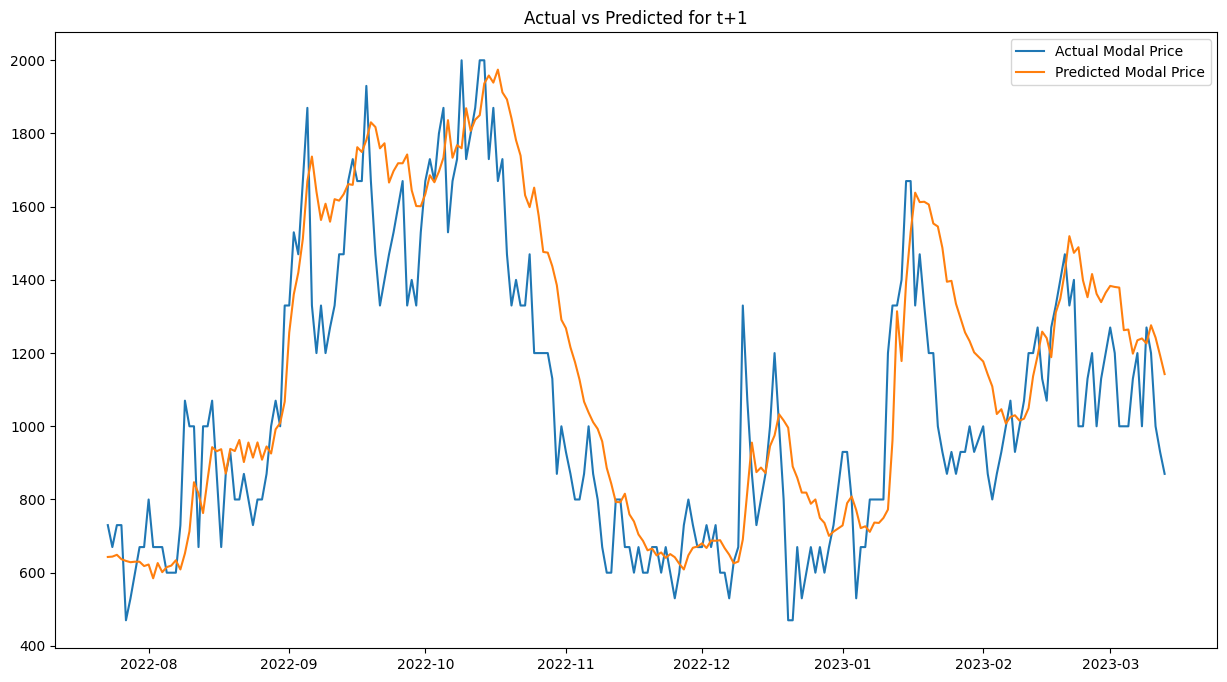

In [69]:
plt.plot(pred2_df['modal_price_actual_t1'], label='Actual Modal Price')
plt.plot(pred2_df['prediction_t1'],  label='Predicted Modal Price')
plt.legend()
plt.title('Actual vs Predicted for t+1')
plt.show()

# Model 3 - Bi Directional LSTM

## Model Building

In [70]:
# Build the Bi-Directional LSTM model
model_biDir = Sequential()
model_biDir.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_biDir.add(Dense(vec_train_y.shape[1]))
model_biDir.compile(optimizer='adam', loss='mae')


In [71]:
model_biDir.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100)              21200     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 5)                 505       
                                                                 
Total params: 21,705
Trainable params: 21,705
Non-trainable params: 0
_________________________________________________________________


In [72]:
# fit network
history_3 = model_biDir.fit(vec_train_X, vec_train_y, epochs=50, batch_size=72, 
                            validation_data=(vec_test_X, vec_test_y), verbose=2,
                            shuffle=False)

Epoch 1/50
13/13 - 4s - loss: 0.1299 - val_loss: 0.0718 - 4s/epoch - 313ms/step
Epoch 2/50
13/13 - 1s - loss: 0.0848 - val_loss: 0.0473 - 523ms/epoch - 40ms/step
Epoch 3/50
13/13 - 1s - loss: 0.0747 - val_loss: 0.0466 - 502ms/epoch - 39ms/step
Epoch 4/50
13/13 - 0s - loss: 0.0695 - val_loss: 0.0453 - 380ms/epoch - 29ms/step
Epoch 5/50
13/13 - 0s - loss: 0.0656 - val_loss: 0.0443 - 388ms/epoch - 30ms/step
Epoch 6/50
13/13 - 0s - loss: 0.0621 - val_loss: 0.0448 - 295ms/epoch - 23ms/step
Epoch 7/50
13/13 - 0s - loss: 0.0604 - val_loss: 0.0434 - 410ms/epoch - 32ms/step
Epoch 8/50
13/13 - 0s - loss: 0.0581 - val_loss: 0.0430 - 379ms/epoch - 29ms/step
Epoch 9/50
13/13 - 0s - loss: 0.0566 - val_loss: 0.0418 - 263ms/epoch - 20ms/step
Epoch 10/50
13/13 - 0s - loss: 0.0547 - val_loss: 0.0406 - 466ms/epoch - 36ms/step
Epoch 11/50
13/13 - 0s - loss: 0.0528 - val_loss: 0.0396 - 309ms/epoch - 24ms/step
Epoch 12/50
13/13 - 0s - loss: 0.0509 - val_loss: 0.0384 - 337ms/epoch - 26ms/step
Epoch 13/50
13/

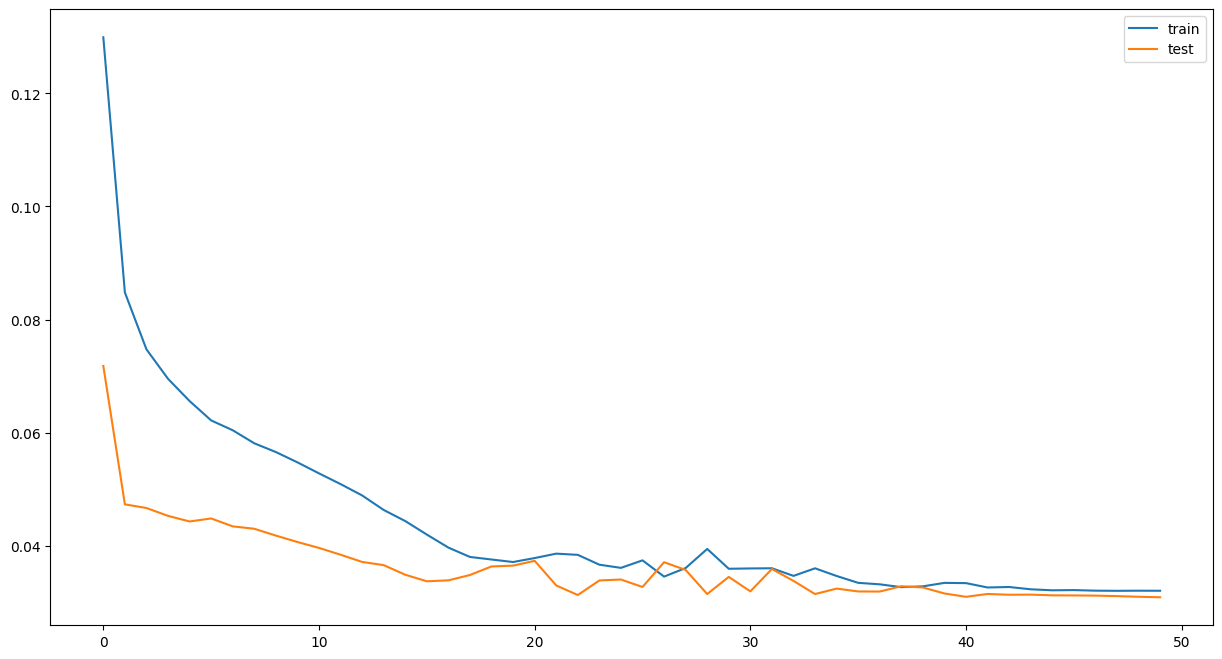

In [73]:
# plot history
plt.plot(history_3.history['loss'], label='train')
plt.plot(history_3.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [74]:
# make a prediction
pred3_y = model_biDir.predict(vec_test_X)

8/8 [==============================] - 0s 6ms/step


In [75]:
pred3_y[:5]

array([[0.0659249 , 0.0718618 , 0.06045361, 0.06561279, 0.06796209],
       [0.06827495, 0.07201434, 0.06268819, 0.06747786, 0.07199824],
       [0.06837673, 0.07345619, 0.06506826, 0.06975237, 0.07225221],
       [0.06966029, 0.07644206, 0.06663656, 0.07078951, 0.07195282],
       [0.06834909, 0.0733071 , 0.06763396, 0.06975185, 0.0717143 ]],
      dtype=float32)

In [76]:
pred3_y.shape

(232, 5)

## Rescaling Prediction

In [77]:
data_pred3 = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)

In [78]:
for i in range(0,5):
  data_pred3['prediction_t'+str(i+1)] = pred3_y[:,i]

In [79]:
data_pred3

,quantity,min_price,max_price,modal_price,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,...,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31,prediction_t1,prediction_t2,prediction_t3,prediction_t4,prediction_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-07-23,0.875515,0.067344,0.072551,0.081034,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,...,0.321667,0.388333,0.421667,0.388333,0.445000,0.065925,0.071862,0.060454,0.065613,0.067962
2022-07-24,0.864548,0.067344,0.081016,0.091379,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,...,0.311667,0.321667,0.388333,0.421667,0.388333,0.068275,0.072014,0.062688,0.067478,0.071998
2022-07-25,0.804913,0.067344,0.105200,0.081034,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,...,0.245000,0.311667,0.321667,0.388333,0.421667,0.068377,0.073456,0.065068,0.069752,0.072252
2022-07-26,0.854483,0.067344,0.105200,0.091379,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,...,0.145000,0.245000,0.311667,0.321667,0.388333,0.069660,0.076442,0.066637,0.070790,0.071953
2022-07-27,0.798577,0.059720,0.096735,0.091379,0.121667,0.111667,0.121667,0.111667,0.111667,0.121667,...,0.121667,0.145000,0.245000,0.311667,0.321667,0.068349,0.073307,0.067634,0.069752,0.071714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,0.085133,0.169287,0.137931,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,...,0.178333,0.166667,0.155000,0.178333,0.166667,0.149321,0.147539,0.149433,0.147232,0.143886
2023-03-10,0.060756,0.118170,0.193470,0.184483,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,...,0.200000,0.178333,0.166667,0.155000,0.178333,0.163217,0.161231,0.162111,0.161711,0.157898
2023-03-11,0.065435,0.085133,0.177751,0.172414,0.211667,0.166667,0.200000,0.188333,0.166667,0.166667,...,0.200000,0.200000,0.178333,0.166667,0.155000,0.156059,0.153386,0.155226,0.154432,0.151544


In [80]:
inv_pred3_y = scaler.inverse_transform(data_pred3)
inv_pred3_y = inv_pred3_y[:,-5:]

In [81]:
inv_pred3_y[:5,]

array([[582.36440718, 616.79841727, 550.63093007, 580.55419922,
        594.18010861],
       [595.99468112, 617.68316776, 563.59148324, 591.37158543,
        617.58978367],
       [596.58501893, 626.04590505, 577.39590704, 604.56371903,
        619.06279773],
       [604.02968824, 643.36392134, 586.49206161, 610.57914943,
        617.32635498],
       [596.42469734, 625.18120557, 592.2769919 , 604.56073731,
        615.94296545]])

## Comapring Actuals vs Predicted

In [82]:
pred3_df = test_data[['quantity']]

In [83]:
for i in range(0,5):
  pred3_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred3_df['prediction_t'+str(i+1)] = inv_pred3_y[:,i]

In [84]:
pred3_df

,quantity,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,,
2022-07-23,0.875515,730.0,582.364407,670.0,616.798417,730.0,550.630930,730.0,580.554199,470.0,594.180109
2022-07-24,0.864548,670.0,595.994681,730.0,617.683168,730.0,563.591483,470.0,591.371585,530.0,617.589784
2022-07-25,0.804913,730.0,596.585019,730.0,626.045905,470.0,577.395907,530.0,604.563719,600.0,619.062798
2022-07-26,0.854483,730.0,604.029688,470.0,643.363921,530.0,586.492062,600.0,610.579149,670.0,617.326355
2022-07-27,0.798577,470.0,596.424697,530.0,625.181206,600.0,592.276992,670.0,604.560737,670.0,615.942965
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,1270.0,1066.060877,1200.0,1055.724326,1000.0,1066.709942,930.0,1053.942984,870.0,1034.541133
2023-03-10,0.060756,1200.0,1146.660030,1000.0,1135.140902,930.0,1140.244055,870.0,1137.921163,930.0,1115.808797
2023-03-11,0.065435,1000.0,1105.142701,930.0,1089.641201,870.0,1100.309804,930.0,1095.706370,730.0,1078.957647


In [85]:
# Calculate the error
error3 = pd.Series()
for i in range(0,5):
  error3['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred3_y[:,i])
print("Results of sklearn.metrics:")
print(error3)

Results of sklearn.metrics:
MAPE_1    0.136073
MAPE_2    0.160359
MAPE_3    0.180898
MAPE_4    0.193336
MAPE_5    0.197296
dtype: float64


In [86]:
model_comparision['BiDir_LSTM'] = error3
model_comparision

,LSTM,Stacked_LSTM,BiDir_LSTM
MAPE_1,0.158445,0.178361,0.136073
MAPE_2,0.174372,0.195842,0.160359
MAPE_3,0.185455,0.224077,0.180898
MAPE_4,0.204731,0.228571,0.193336
MAPE_5,0.208217,0.239831,0.197296


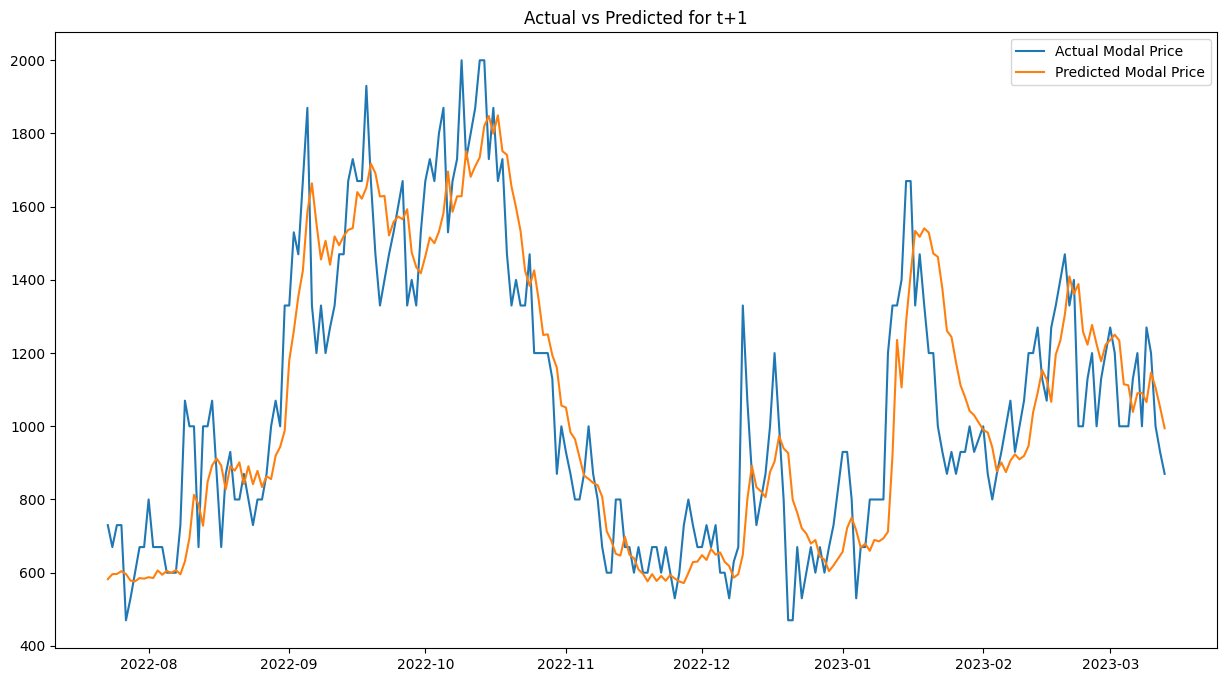

In [87]:
plt.plot(pred3_df['modal_price_actual_t1'], label='Actual Modal Price')
plt.plot(pred3_df['prediction_t1'],  label='Predicted Modal Price')
plt.legend()
plt.title('Actual vs Predicted for t+1')
plt.show()

# Model 4 - Stacked Bi Directional LSTM

## Model Building

In [88]:
# Build the Stacked Bi-Directional LSTM model
model_Stacked_biDir = Sequential()
model_Stacked_biDir.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir.add(Bidirectional(LSTM(50, activation='relu')))
model_Stacked_biDir.add(Dense(vec_train_y.shape[1]))
model_Stacked_biDir.compile(optimizer='adam', loss='mae')


In [89]:
model_Stacked_biDir.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 17, 100)          21200     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 5)                 505       
                                                                 
Total params: 82,105
Trainable params: 82,105
Non-trainable params: 0
_________________________________________________________________


In [90]:
# fit network
history_4 = model_Stacked_biDir.fit(vec_train_X, vec_train_y, epochs=50, batch_size=72, 
                                    validation_data=(vec_test_X, vec_test_y), verbose=2,
                                    shuffle=False)

Epoch 1/50
13/13 - 10s - loss: 0.1143 - val_loss: 0.0480 - 10s/epoch - 794ms/step
Epoch 2/50
13/13 - 1s - loss: 0.0823 - val_loss: 0.0476 - 1s/epoch - 91ms/step
Epoch 3/50
13/13 - 1s - loss: 0.0726 - val_loss: 0.0447 - 1s/epoch - 110ms/step
Epoch 4/50
13/13 - 1s - loss: 0.0673 - val_loss: 0.0468 - 1s/epoch - 85ms/step
Epoch 5/50
13/13 - 1s - loss: 0.0641 - val_loss: 0.0444 - 925ms/epoch - 71ms/step
Epoch 6/50
13/13 - 1s - loss: 0.0600 - val_loss: 0.0447 - 942ms/epoch - 72ms/step
Epoch 7/50
13/13 - 1s - loss: 0.0584 - val_loss: 0.0426 - 778ms/epoch - 60ms/step
Epoch 8/50
13/13 - 2s - loss: 0.0551 - val_loss: 0.0427 - 2s/epoch - 118ms/step
Epoch 9/50
13/13 - 1s - loss: 0.0535 - val_loss: 0.0403 - 1s/epoch - 115ms/step
Epoch 10/50
13/13 - 2s - loss: 0.0507 - val_loss: 0.0386 - 2s/epoch - 135ms/step
Epoch 11/50
13/13 - 1s - loss: 0.0476 - val_loss: 0.0372 - 1s/epoch - 83ms/step
Epoch 12/50
13/13 - 1s - loss: 0.0448 - val_loss: 0.0360 - 716ms/epoch - 55ms/step
Epoch 13/50
13/13 - 1s - loss:

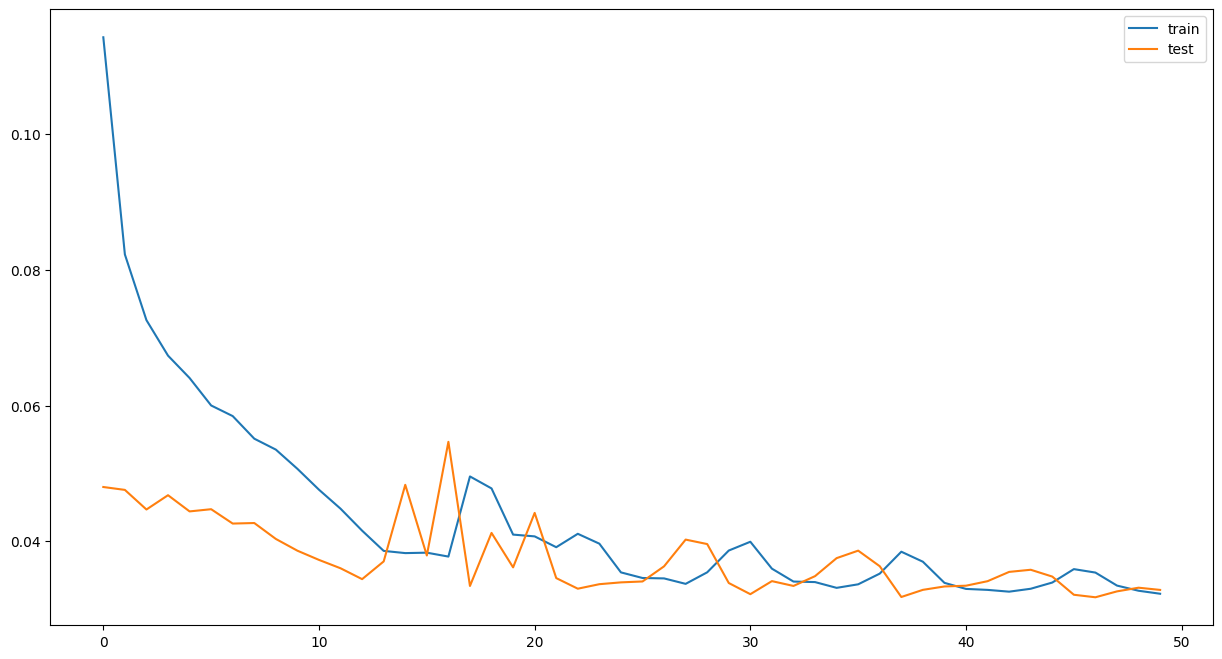

In [91]:
# plot history
plt.plot(history_4.history['loss'], label='train')
plt.plot(history_4.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [92]:
# make a prediction
pred4_y = model_Stacked_biDir.predict(vec_test_X)

8/8 [==============================] - 1s 9ms/step


In [93]:
pred4_y[:5]

array([[0.06588975, 0.05999757, 0.05862401, 0.06324371, 0.05734987],
       [0.0668927 , 0.06168863, 0.06063692, 0.06472962, 0.05946371],
       [0.06734707, 0.06288427, 0.06236266, 0.06596225, 0.06101571],
       [0.0681754 , 0.06396627, 0.0639327 , 0.06692331, 0.06225707],
       [0.06745327, 0.06430027, 0.06452972, 0.06623308, 0.0625044 ]],
      dtype=float32)

In [94]:
pred4_y.shape

(232, 5)

## Rescaling Prediction

In [95]:
data_pred4 = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)

In [96]:
for i in range(0,5):
  data_pred4['prediction_t'+str(i+1)] = pred4_y[:,i]

In [97]:
data_pred4

,quantity,min_price,max_price,modal_price,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,...,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31,prediction_t1,prediction_t2,prediction_t3,prediction_t4,prediction_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-07-23,0.875515,0.067344,0.072551,0.081034,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,...,0.321667,0.388333,0.421667,0.388333,0.445000,0.065890,0.059998,0.058624,0.063244,0.057350
2022-07-24,0.864548,0.067344,0.081016,0.091379,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,...,0.311667,0.321667,0.388333,0.421667,0.388333,0.066893,0.061689,0.060637,0.064730,0.059464
2022-07-25,0.804913,0.067344,0.105200,0.081034,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,...,0.245000,0.311667,0.321667,0.388333,0.421667,0.067347,0.062884,0.062363,0.065962,0.061016
2022-07-26,0.854483,0.067344,0.105200,0.091379,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,...,0.145000,0.245000,0.311667,0.321667,0.388333,0.068175,0.063966,0.063933,0.066923,0.062257
2022-07-27,0.798577,0.059720,0.096735,0.091379,0.121667,0.111667,0.121667,0.111667,0.111667,0.121667,...,0.121667,0.145000,0.245000,0.311667,0.321667,0.067453,0.064300,0.064530,0.066233,0.062504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,0.085133,0.169287,0.137931,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,...,0.178333,0.166667,0.155000,0.178333,0.166667,0.150732,0.152771,0.148616,0.148282,0.145235
2023-03-10,0.060756,0.118170,0.193470,0.184483,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,...,0.200000,0.178333,0.166667,0.155000,0.178333,0.170795,0.170765,0.166313,0.166983,0.161927
2023-03-11,0.065435,0.085133,0.177751,0.172414,0.211667,0.166667,0.200000,0.188333,0.166667,0.166667,...,0.200000,0.200000,0.178333,0.166667,0.155000,0.158633,0.160026,0.155699,0.156211,0.152509


In [98]:
inv_pred4_y = scaler.inverse_transform(data_pred4)
inv_pred4_y = inv_pred4_y[:,-5:]

In [99]:
inv_pred4_y[:5,]

array([[582.16056973, 547.98588306, 540.0192827 , 566.81351513,
        532.62923509],
       [587.97765076, 557.79406428, 551.69413015, 575.43177307,
        544.88953725],
       [590.61301798, 564.72877264, 561.70340478, 582.58103579,
        553.89114097],
       [595.41730732, 571.0043475 , 570.80967128, 588.15521449,
        561.09102815],
       [591.2289381 , 572.94155955, 574.27235842, 584.15188491,
        562.52549589]])

## Comapring Actuals vs Predicted

In [100]:
pred4_df = test_data[['quantity']]

In [101]:
for i in range(0,5):
  pred4_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred4_df['prediction_t'+str(i+1)] = inv_pred4_y[:,i]

In [102]:
pred4_df

,quantity,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,,
2022-07-23,0.875515,730.0,582.160570,670.0,547.985883,730.0,540.019283,730.0,566.813515,470.0,532.629235
2022-07-24,0.864548,670.0,587.977651,730.0,557.794064,730.0,551.694130,470.0,575.431773,530.0,544.889537
2022-07-25,0.804913,730.0,590.613018,730.0,564.728773,470.0,561.703405,530.0,582.581036,600.0,553.891141
2022-07-26,0.854483,730.0,595.417307,470.0,571.004348,530.0,570.809671,600.0,588.155214,670.0,561.091028
2022-07-27,0.798577,470.0,591.228938,530.0,572.941560,600.0,574.272358,670.0,584.151885,670.0,562.525496
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,1270.0,1074.245057,1200.0,1086.069357,1000.0,1061.974621,930.0,1060.033303,870.0,1042.363358
2023-03-10,0.060756,1200.0,1190.613642,1000.0,1190.436900,930.0,1164.614579,870.0,1168.498769,930.0,1139.175043
2023-03-11,0.065435,1000.0,1120.069462,930.0,1128.152090,870.0,1103.055754,930.0,1106.025809,730.0,1084.553432


In [103]:
# Calculate the error
error4 = pd.Series()
for i in range(0,5):
  error4['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred4_y[:,i])
print("Results of sklearn.metrics:")
print(error4)

Results of sklearn.metrics:
MAPE_1    0.139361
MAPE_2    0.172268
MAPE_3    0.189287
MAPE_4    0.207456
MAPE_5    0.220155
dtype: float64


In [104]:
model_comparision['Stacked_BiDir_LSTM'] = error4
model_comparision

,LSTM,Stacked_LSTM,BiDir_LSTM,Stacked_BiDir_LSTM
MAPE_1,0.158445,0.178361,0.136073,0.139361
MAPE_2,0.174372,0.195842,0.160359,0.172268
MAPE_3,0.185455,0.224077,0.180898,0.189287
MAPE_4,0.204731,0.228571,0.193336,0.207456
MAPE_5,0.208217,0.239831,0.197296,0.220155


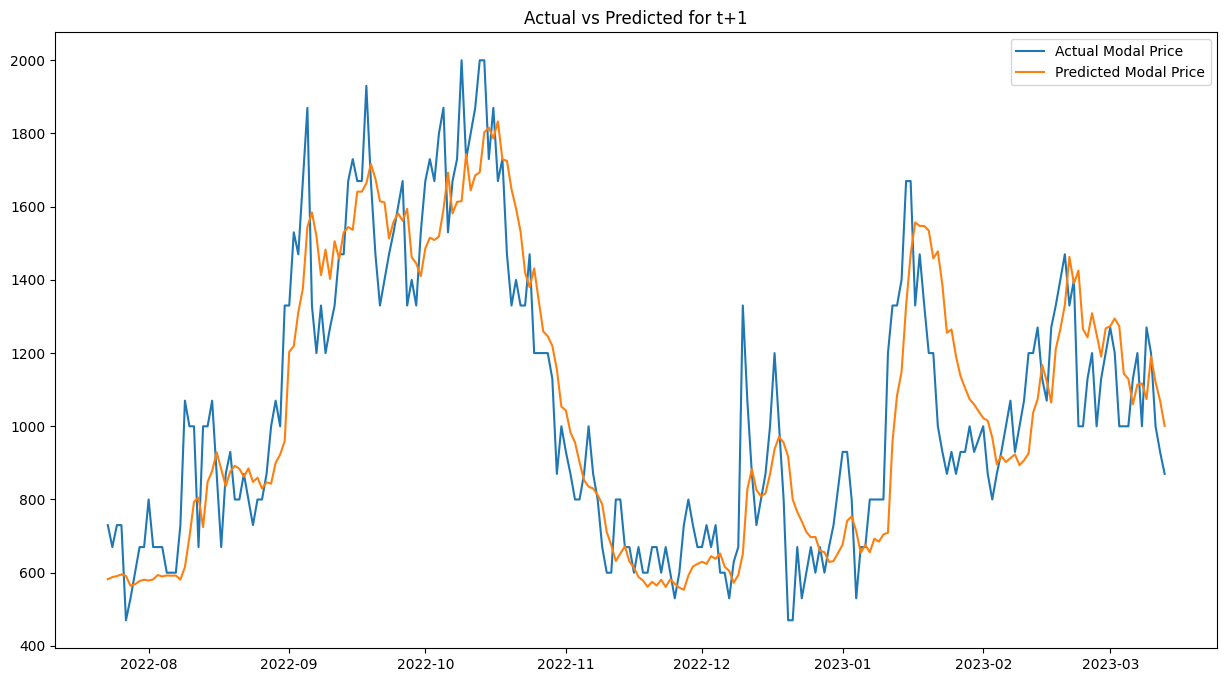

In [105]:
plt.plot(pred4_df['modal_price_actual_t1'], label='Actual Modal Price')
plt.plot(pred4_df['prediction_t1'],  label='Predicted Modal Price')
plt.legend()
plt.title('Actual vs Predicted for t+1')
plt.show()

# Model 5 - Stacked Bi Directional LSTM With LSTM

## Model Building

In [106]:
# Build the Stacked Bi-Directional LSTM model
model_Stacked_biDir2 = Sequential()
model_Stacked_biDir2.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir2.add(LSTM(50, activation='relu'))
model_Stacked_biDir2.add(Dense(vec_train_y.shape[1]))
model_Stacked_biDir2.compile(optimizer='adam', loss='mae')


In [107]:
# fit network
history_5 = model_Stacked_biDir2.fit(vec_train_X, vec_train_y, epochs=50, batch_size=72, 
                                    validation_data=(vec_test_X, vec_test_y), verbose=2,
                                    shuffle=False)

Epoch 1/50
13/13 - 6s - loss: 0.1189 - val_loss: 0.0579 - 6s/epoch - 452ms/step
Epoch 2/50
13/13 - 1s - loss: 0.0863 - val_loss: 0.0488 - 780ms/epoch - 60ms/step
Epoch 3/50
13/13 - 1s - loss: 0.0779 - val_loss: 0.0484 - 784ms/epoch - 60ms/step
Epoch 4/50
13/13 - 1s - loss: 0.0735 - val_loss: 0.0491 - 569ms/epoch - 44ms/step
Epoch 5/50
13/13 - 0s - loss: 0.0701 - val_loss: 0.0493 - 438ms/epoch - 34ms/step
Epoch 6/50
13/13 - 0s - loss: 0.0693 - val_loss: 0.0472 - 422ms/epoch - 32ms/step
Epoch 7/50
13/13 - 0s - loss: 0.0666 - val_loss: 0.0467 - 438ms/epoch - 34ms/step
Epoch 8/50
13/13 - 0s - loss: 0.0653 - val_loss: 0.0444 - 480ms/epoch - 37ms/step
Epoch 9/50
13/13 - 1s - loss: 0.0626 - val_loss: 0.0439 - 801ms/epoch - 62ms/step
Epoch 10/50
13/13 - 1s - loss: 0.0603 - val_loss: 0.0443 - 797ms/epoch - 61ms/step
Epoch 11/50
13/13 - 1s - loss: 0.0596 - val_loss: 0.0404 - 586ms/epoch - 45ms/step
Epoch 12/50
13/13 - 1s - loss: 0.0541 - val_loss: 0.0434 - 784ms/epoch - 60ms/step
Epoch 13/50
13/

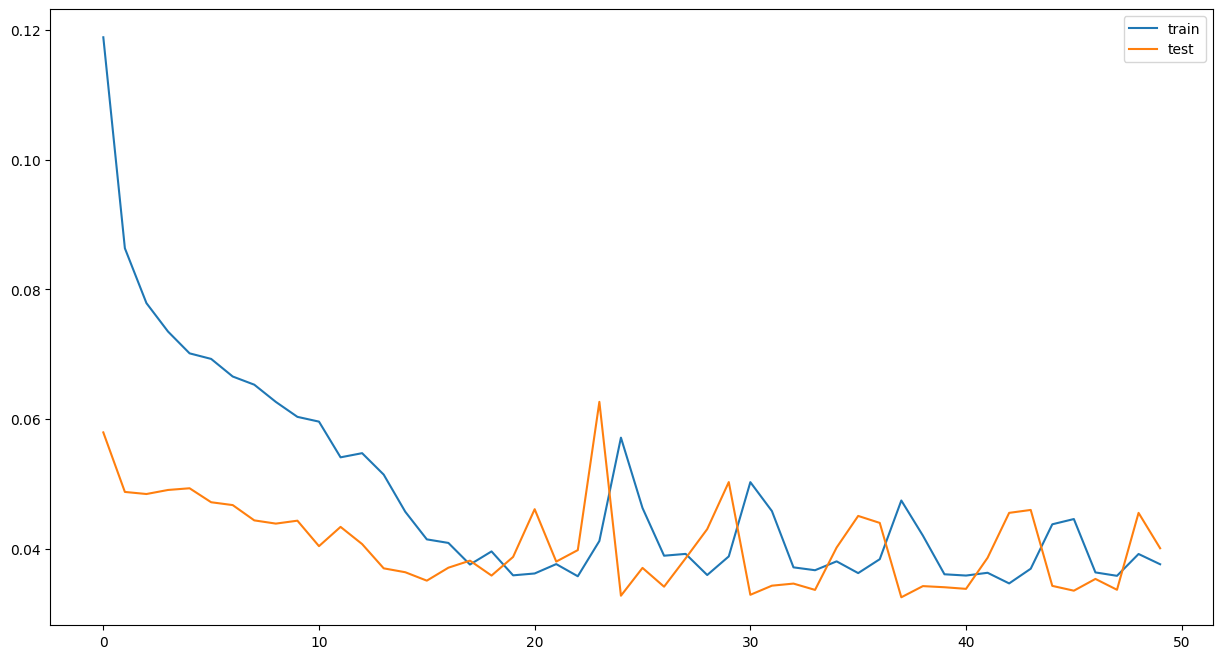

In [108]:
# plot history
plt.plot(history_5.history['loss'], label='train')
plt.plot(history_5.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [109]:
# make a prediction
pred5_y = model_Stacked_biDir2.predict(vec_test_X)

8/8 [==============================] - 0s 7ms/step


In [110]:
pred5_y[:5]

array([[0.09704725, 0.08865032, 0.08354598, 0.08147995, 0.08686356],
       [0.09709509, 0.08983754, 0.08548289, 0.08373101, 0.08912314],
       [0.09860197, 0.09144868, 0.08810621, 0.08649445, 0.09199031],
       [0.10038069, 0.09449863, 0.09174591, 0.09067345, 0.09624083],
       [0.09987807, 0.09504615, 0.09271808, 0.09267845, 0.09772927]],
      dtype=float32)

In [111]:
pred5_y.shape

(232, 5)

## Rescaling Prediction

In [112]:
data_pred5 = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)

In [113]:
for i in range(0,5):
  data_pred5['prediction_t'+str(i+1)] = pred5_y[:,i]

In [114]:
data_pred5

,quantity,min_price,max_price,modal_price,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,...,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31,prediction_t1,prediction_t2,prediction_t3,prediction_t4,prediction_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-07-23,0.875515,0.067344,0.072551,0.081034,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,...,0.321667,0.388333,0.421667,0.388333,0.445000,0.097047,0.088650,0.083546,0.081480,0.086864
2022-07-24,0.864548,0.067344,0.081016,0.091379,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,...,0.311667,0.321667,0.388333,0.421667,0.388333,0.097095,0.089838,0.085483,0.083731,0.089123
2022-07-25,0.804913,0.067344,0.105200,0.081034,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,...,0.245000,0.311667,0.321667,0.388333,0.421667,0.098602,0.091449,0.088106,0.086494,0.091990
2022-07-26,0.854483,0.067344,0.105200,0.091379,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,...,0.145000,0.245000,0.311667,0.321667,0.388333,0.100381,0.094499,0.091746,0.090673,0.096241
2022-07-27,0.798577,0.059720,0.096735,0.091379,0.121667,0.111667,0.121667,0.111667,0.111667,0.121667,...,0.121667,0.145000,0.245000,0.311667,0.321667,0.099878,0.095046,0.092718,0.092678,0.097729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,0.085133,0.169287,0.137931,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,...,0.178333,0.166667,0.155000,0.178333,0.166667,0.180976,0.180719,0.180915,0.184605,0.184837
2023-03-10,0.060756,0.118170,0.193470,0.184483,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,...,0.200000,0.178333,0.166667,0.155000,0.178333,0.195538,0.195148,0.195486,0.199354,0.199254
2023-03-11,0.065435,0.085133,0.177751,0.172414,0.211667,0.166667,0.200000,0.188333,0.166667,0.166667,...,0.200000,0.200000,0.178333,0.166667,0.155000,0.185111,0.184587,0.184793,0.188230,0.188459


In [115]:
inv_pred5_y = scaler.inverse_transform(data_pred5)
inv_pred5_y = inv_pred5_y[:,-5:]

In [116]:
inv_pred5_y[:5,]

array([[762.87403256, 714.17187601, 684.56670046, 672.58372009,
        703.8086623 ],
       [763.15150559, 721.05771005, 695.80074996, 685.63986123,
        716.91419631],
       [771.89140916, 730.40234149, 711.01600379, 701.66778564,
        733.54378045],
       [782.20799565, 748.09203595, 732.12625235, 725.9059906 ,
        758.19679052],
       [779.29277867, 751.26765668, 737.76486218, 737.53501028,
        766.829741  ]])

## Comapring Actuals vs Predicted

In [117]:
pred5_df = test_data[['quantity']]

In [118]:
for i in range(0,5):
  pred5_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred5_df['prediction_t'+str(i+1)] = inv_pred5_y[:,i]

In [119]:
pred5_df

,quantity,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,,
2022-07-23,0.875515,730.0,762.874033,670.0,714.171876,730.0,684.566700,730.0,672.583720,470.0,703.808662
2022-07-24,0.864548,670.0,763.151506,730.0,721.057710,730.0,695.800750,470.0,685.639861,530.0,716.914196
2022-07-25,0.804913,730.0,771.891409,730.0,730.402341,470.0,711.016004,530.0,701.667786,600.0,733.543780
2022-07-26,0.854483,730.0,782.207996,470.0,748.092036,530.0,732.126252,600.0,725.905991,670.0,758.196791
2022-07-27,0.798577,470.0,779.292779,530.0,751.267657,600.0,737.764862,670.0,737.535010,670.0,766.829741
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,1270.0,1249.658054,1200.0,1248.172033,1000.0,1249.308977,930.0,1270.710310,870.0,1272.053209
2023-03-10,0.060756,1200.0,1334.120655,1000.0,1331.856188,930.0,1333.817038,870.0,1356.251344,930.0,1355.671248
2023-03-11,0.065435,1000.0,1273.644671,930.0,1270.607030,870.0,1271.799633,930.0,1291.736293,730.0,1293.063289


In [120]:
# Calculate the error
error5 = pd.Series()
for i in range(0,5):
  error5['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred5_y[:,i])
print("Results of sklearn.metrics:")
print(error5)

Results of sklearn.metrics:
MAPE_1    0.210002
MAPE_2    0.224937
MAPE_3    0.239350
MAPE_4    0.264042
MAPE_5    0.284243
dtype: float64


In [121]:
model_comparision['Stacked_BiDir_LSTM_2'] = error5
model_comparision

,LSTM,Stacked_LSTM,BiDir_LSTM,Stacked_BiDir_LSTM,Stacked_BiDir_LSTM_2
MAPE_1,0.158445,0.178361,0.136073,0.139361,0.210002
MAPE_2,0.174372,0.195842,0.160359,0.172268,0.224937
MAPE_3,0.185455,0.224077,0.180898,0.189287,0.239350
MAPE_4,0.204731,0.228571,0.193336,0.207456,0.264042
MAPE_5,0.208217,0.239831,0.197296,0.220155,0.284243


# Model 6 - Stacked Bi Directional LSTM (Model 4 with more Epochs)

## Model Building

In [122]:
# Build the Stacked Bi-Directional LSTM model
model_Stacked_biDir3 = Sequential()
model_Stacked_biDir3.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir3.add(Bidirectional(LSTM(50, activation='relu')))
model_Stacked_biDir3.add(Dense(vec_train_y.shape[1]))
model_Stacked_biDir3.compile(optimizer='adam', loss='mae')

In [123]:
model_Stacked_biDir3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 17, 100)          21200     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 5)                 505       
                                                                 
Total params: 82,105
Trainable params: 82,105
Non-trainable params: 0
_________________________________________________________________


In [124]:
# fit network
history_6 = model_Stacked_biDir3.fit(vec_train_X, vec_train_y, epochs=300, batch_size=100, 
                                    validation_data=(vec_test_X, vec_test_y), verbose=2,
                                    shuffle=False)

Epoch 1/300
10/10 - 7s - loss: 0.1219 - val_loss: 0.0530 - 7s/epoch - 730ms/step
Epoch 2/300
10/10 - 1s - loss: 0.0833 - val_loss: 0.0479 - 579ms/epoch - 58ms/step
Epoch 3/300
10/10 - 1s - loss: 0.0768 - val_loss: 0.0453 - 581ms/epoch - 58ms/step
Epoch 4/300
10/10 - 1s - loss: 0.0708 - val_loss: 0.0455 - 594ms/epoch - 59ms/step
Epoch 5/300
10/10 - 1s - loss: 0.0647 - val_loss: 0.0459 - 579ms/epoch - 58ms/step
Epoch 6/300
10/10 - 1s - loss: 0.0613 - val_loss: 0.0464 - 593ms/epoch - 59ms/step
Epoch 7/300
10/10 - 1s - loss: 0.0596 - val_loss: 0.0450 - 596ms/epoch - 60ms/step
Epoch 8/300
10/10 - 1s - loss: 0.0578 - val_loss: 0.0444 - 585ms/epoch - 58ms/step
Epoch 9/300
10/10 - 1s - loss: 0.0566 - val_loss: 0.0430 - 1s/epoch - 129ms/step
Epoch 10/300
10/10 - 1s - loss: 0.0549 - val_loss: 0.0422 - 603ms/epoch - 60ms/step
Epoch 11/300
10/10 - 1s - loss: 0.0533 - val_loss: 0.0408 - 1s/epoch - 109ms/step
Epoch 12/300
10/10 - 1s - loss: 0.0515 - val_loss: 0.0394 - 1s/epoch - 121ms/step
Epoch 13/

In [125]:
# fit network
#history_6 = model_Stacked_biDir3.fit(vec_train_X, vec_train_y, initial_epoch=100, epochs=200,
#                                     batch_size=32, validation_data=(vec_test_X, vec_test_y), 
#                                    verbose=2, shuffle=False)

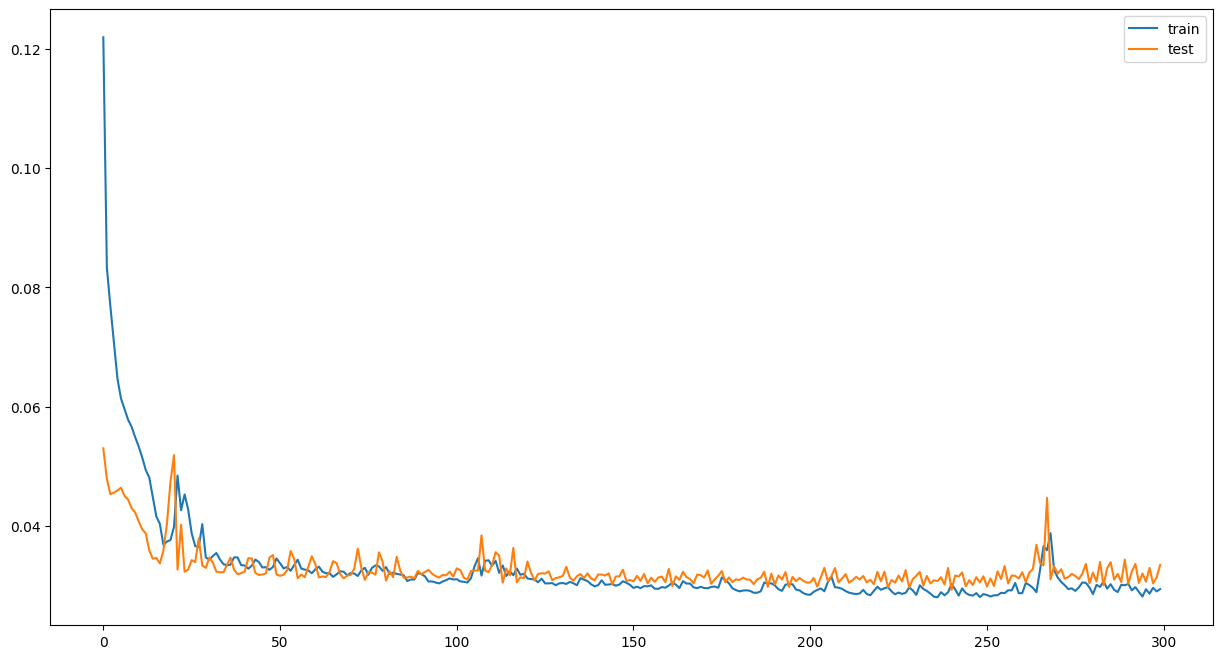

In [126]:
# plot history
plt.plot(history_6.history['loss'], label='train')
plt.plot(history_6.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [127]:
# make a prediction
pred6_y = model_Stacked_biDir3.predict(vec_test_X)

8/8 [==============================] - 1s 9ms/step


In [128]:
pred6_y[:5]

array([[0.08611505, 0.07936396, 0.08390187, 0.08216172, 0.08373453],
       [0.08536112, 0.0789909 , 0.08300945, 0.08115132, 0.08350277],
       [0.08714985, 0.07956512, 0.08304313, 0.08112545, 0.08458497],
       [0.08531811, 0.07832892, 0.0812685 , 0.07951744, 0.083018  ],
       [0.08314829, 0.0771869 , 0.07966764, 0.07736836, 0.08151379]],
      dtype=float32)

In [129]:
pred6_y.shape

(232, 5)

## Rescaling Prediction

In [130]:
data_pred6 = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)

In [131]:
for i in range(0,5):
  data_pred6['prediction_t'+str(i+1)] = pred6_y[:,i]

In [132]:
data_pred6

,quantity,min_price,max_price,modal_price,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,...,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31,prediction_t1,prediction_t2,prediction_t3,prediction_t4,prediction_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-07-23,0.875515,0.067344,0.072551,0.081034,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,...,0.321667,0.388333,0.421667,0.388333,0.445000,0.086115,0.079364,0.083902,0.082162,0.083735
2022-07-24,0.864548,0.067344,0.081016,0.091379,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,...,0.311667,0.321667,0.388333,0.421667,0.388333,0.085361,0.078991,0.083009,0.081151,0.083503
2022-07-25,0.804913,0.067344,0.105200,0.081034,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,...,0.245000,0.311667,0.321667,0.388333,0.421667,0.087150,0.079565,0.083043,0.081125,0.084585
2022-07-26,0.854483,0.067344,0.105200,0.091379,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,...,0.145000,0.245000,0.311667,0.321667,0.388333,0.085318,0.078329,0.081269,0.079517,0.083018
2022-07-27,0.798577,0.059720,0.096735,0.091379,0.121667,0.111667,0.121667,0.111667,0.111667,0.121667,...,0.121667,0.145000,0.245000,0.311667,0.321667,0.083148,0.077187,0.079668,0.077368,0.081514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,0.085133,0.169287,0.137931,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,...,0.178333,0.166667,0.155000,0.178333,0.166667,0.161332,0.160336,0.165333,0.165920,0.160118
2023-03-10,0.060756,0.118170,0.193470,0.184483,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,...,0.200000,0.178333,0.166667,0.155000,0.178333,0.185907,0.182128,0.186719,0.189335,0.183903
2023-03-11,0.065435,0.085133,0.177751,0.172414,0.211667,0.166667,0.200000,0.188333,0.166667,0.166667,...,0.200000,0.200000,0.178333,0.166667,0.155000,0.172121,0.171511,0.177397,0.179132,0.173180


In [133]:
inv_pred6_y = scaler.inverse_transform(data_pred6)
inv_pred6_y = inv_pred6_y[:,-5:]

In [134]:
inv_pred6_y[:5,]

array([[699.46731776, 660.31095088, 686.63083017, 676.53795928,
        685.66025794],
       [695.09447068, 658.14721435, 681.45481944, 670.67766488,
        684.31606293],
       [705.46913594, 661.4777118 , 681.65014386, 670.52762806,
        690.59280455],
       [694.84504312, 654.30774987, 671.35732472, 661.20114625,
        681.50442839],
       [682.26005733, 647.68404812, 662.07232773, 648.73650968,
        672.7799952 ]])

## Comapring Actuals vs Predicted

In [135]:
pred6_df = test_data[['quantity']]

In [136]:
for i in range(0,5):
  pred6_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred6_df['prediction_t'+str(i+1)] = inv_pred6_y[:,i]

In [137]:
pred6_df

,quantity,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,,
2022-07-23,0.875515,730.0,699.467318,670.0,660.310951,730.0,686.630830,730.0,676.537959,470.0,685.660258
2022-07-24,0.864548,670.0,695.094471,730.0,658.147214,730.0,681.454819,470.0,670.677665,530.0,684.316063
2022-07-25,0.804913,730.0,705.469136,730.0,661.477712,470.0,681.650144,530.0,670.527628,600.0,690.592805
2022-07-26,0.854483,730.0,694.845043,470.0,654.307750,530.0,671.357325,600.0,661.201146,670.0,681.504428
2022-07-27,0.798577,470.0,682.260057,530.0,647.684048,600.0,662.072328,670.0,648.736510,670.0,672.779995
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,1270.0,1135.722899,1200.0,1129.950976,1000.0,1158.929947,930.0,1162.338185,870.0,1128.685516
2023-03-10,0.060756,1200.0,1278.262192,1000.0,1256.343681,930.0,1282.968906,870.0,1298.142761,930.0,1266.639957
2023-03-11,0.065435,1000.0,1198.301905,930.0,1194.766274,870.0,1228.904834,930.0,1238.967586,730.0,1204.441833


In [138]:
mean_absolute_percentage_error(inv_test_y[:,0],inv_pred6_y[:,0])

0.13513133870470312

In [139]:
# Calculate the error
error6 = pd.Series()
for i in range(0,5):
  error6['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred6_y[:,i])
print("Results of sklearn.metrics:")
print(error6)

Results of sklearn.metrics:
MAPE_1    0.135131
MAPE_2    0.174448
MAPE_3    0.214917
MAPE_4    0.230775
MAPE_5    0.241835
dtype: float64


In [140]:
model_comparision['Stacked_BiDir_LSTM_3'] = error6
model_comparision

,LSTM,Stacked_LSTM,BiDir_LSTM,Stacked_BiDir_LSTM,Stacked_BiDir_LSTM_2,Stacked_BiDir_LSTM_3
MAPE_1,0.158445,0.178361,0.136073,0.139361,0.210002,0.135131
MAPE_2,0.174372,0.195842,0.160359,0.172268,0.224937,0.174448
MAPE_3,0.185455,0.224077,0.180898,0.189287,0.239350,0.214917
MAPE_4,0.204731,0.228571,0.193336,0.207456,0.264042,0.230775
MAPE_5,0.208217,0.239831,0.197296,0.220155,0.284243,0.241835


# Model 7 - Stacked Bi Directional LSTM (Hyperparameter tuning) - Reducing the nodes in hidden layer

## Model Building

In [141]:
# Build the Stacked Bi-Directional LSTM model
model_Stacked_biDir_h1 = Sequential()
model_Stacked_biDir_h1.add(Bidirectional(LSTM(8, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir_h1.add(Dropout(0.2))
model_Stacked_biDir_h1.add(BatchNormalization())
model_Stacked_biDir_h1.add(Bidirectional(LSTM(8, activation='relu')))
model_Stacked_biDir_h1.add(Dropout(0.2))
#model_Stacked_biDir_h1.add(BatchNormalization())
model_Stacked_biDir_h1.add(Dense(vec_train_y.shape[1]))
model_Stacked_biDir_h1.compile(optimizer='adam', loss='mae')

In [142]:
model_Stacked_biDir_h1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 17, 16)           704       
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 17, 16)            0         
                                                                 
 batch_normalization (BatchN  (None, 17, 16)           64        
 ormalization)                                                   
                                                                 
 bidirectional_7 (Bidirectio  (None, 16)               1600      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                      

In [143]:
# fit network
history_7 = model_Stacked_biDir_h1.fit(vec_train_X, vec_train_y, epochs=300, batch_size=100, 
                                    validation_data=(vec_test_X, vec_test_y), verbose=0,
                                    shuffle=False)

In [144]:
# fit network
#history_6 = model_Stacked_biDir3.fit(vec_train_X, vec_train_y, initial_epoch=100, epochs=200,
#                                     batch_size=32, validation_data=(vec_test_X, vec_test_y), 
#                                    verbose=2, shuffle=False)

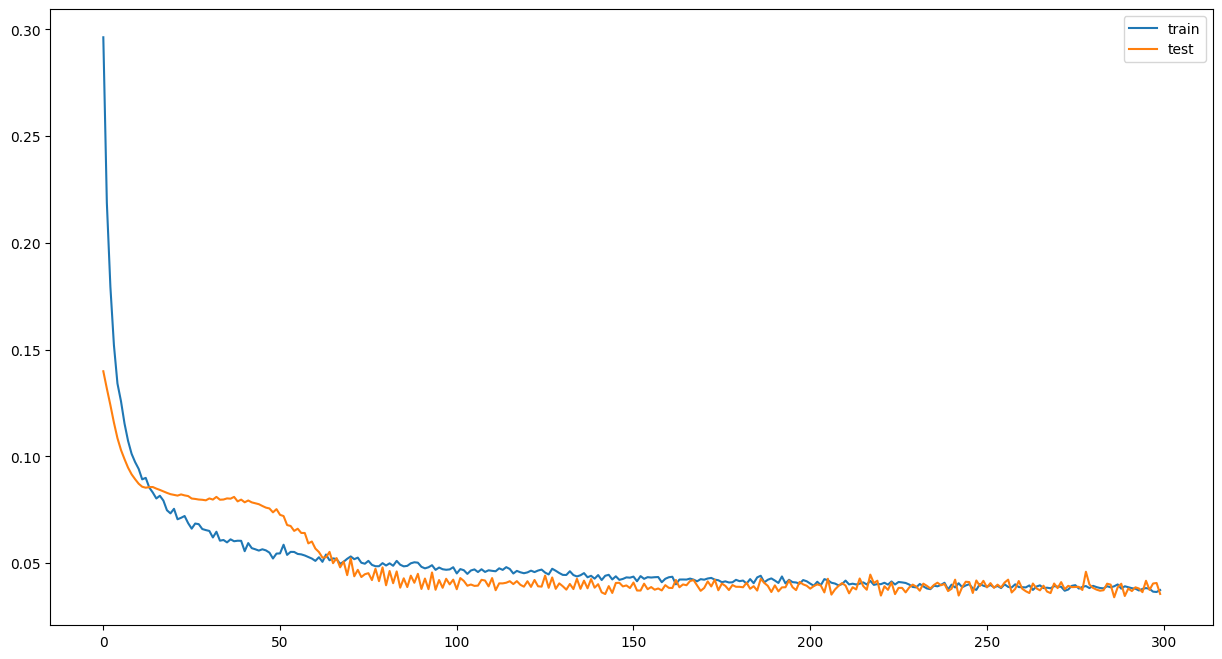

In [145]:
# plot history
plt.plot(history_7.history['loss'], label='train')
plt.plot(history_7.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [146]:
# make a prediction
pred7_y = model_Stacked_biDir_h1.predict(vec_test_X)

8/8 [==============================] - 1s 5ms/step


In [147]:
pred7_y[:5]

array([[0.06769998, 0.06749746, 0.06869098, 0.06554566, 0.06624088],
       [0.05931354, 0.05877759, 0.05984685, 0.05783065, 0.05934097],
       [0.05984323, 0.06021265, 0.06145157, 0.05845447, 0.06003568],
       [0.05690592, 0.05689669, 0.05802688, 0.05598845, 0.0576347 ],
       [0.05780552, 0.05784734, 0.05914926, 0.05663829, 0.05834771]],
      dtype=float32)

In [148]:
pred7_y.shape

(232, 5)

## Rescaling Prediction

In [149]:
data_pred7 = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)

In [150]:
for i in range(0,5):
  data_pred7['prediction_t'+str(i+1)] = pred7_y[:,i]

In [151]:
data_pred7

,quantity,min_price,max_price,modal_price,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,...,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31,prediction_t1,prediction_t2,prediction_t3,prediction_t4,prediction_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-07-23,0.875515,0.067344,0.072551,0.081034,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,...,0.321667,0.388333,0.421667,0.388333,0.445000,0.067700,0.067497,0.068691,0.065546,0.066241
2022-07-24,0.864548,0.067344,0.081016,0.091379,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,...,0.311667,0.321667,0.388333,0.421667,0.388333,0.059314,0.058778,0.059847,0.057831,0.059341
2022-07-25,0.804913,0.067344,0.105200,0.081034,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,...,0.245000,0.311667,0.321667,0.388333,0.421667,0.059843,0.060213,0.061452,0.058454,0.060036
2022-07-26,0.854483,0.067344,0.105200,0.091379,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,...,0.145000,0.245000,0.311667,0.321667,0.388333,0.056906,0.056897,0.058027,0.055988,0.057635
2022-07-27,0.798577,0.059720,0.096735,0.091379,0.121667,0.111667,0.121667,0.111667,0.111667,0.121667,...,0.121667,0.145000,0.245000,0.311667,0.321667,0.057806,0.057847,0.059149,0.056638,0.058348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,0.085133,0.169287,0.137931,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,...,0.178333,0.166667,0.155000,0.178333,0.166667,0.140782,0.145907,0.149724,0.148129,0.152093
2023-03-10,0.060756,0.118170,0.193470,0.184483,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,...,0.200000,0.178333,0.166667,0.155000,0.178333,0.162639,0.169045,0.174077,0.167727,0.176477
2023-03-11,0.065435,0.085133,0.177751,0.172414,0.211667,0.166667,0.200000,0.188333,0.166667,0.166667,...,0.200000,0.200000,0.178333,0.166667,0.155000,0.136587,0.140947,0.144436,0.144029,0.146894


In [152]:
inv_pred7_y = scaler.inverse_transform(data_pred7)
inv_pred7_y = inv_pred7_y[:,-5:]

In [153]:
inv_pred7_y[:5,]

array([[592.65986234, 591.4852798 , 598.40767235, 580.16484678,
        584.1970861 ],
       [544.018507  , 540.91003984, 547.11174145, 535.41775048,
        544.17759702],
       [547.09071815, 549.23334494, 556.41912296, 539.03591931,
        548.20694104],
       [530.05432338, 530.00082523, 536.55592576, 524.73302931,
        534.28128213],
       [535.272035  , 535.51459163, 543.06569546, 528.50209922,
        538.41669336]])

## Comapring Actuals vs Predicted

In [154]:
pred7_df = test_data[['quantity']]

In [155]:
for i in range(0,5):
  pred7_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred7_df['prediction_t'+str(i+1)] = inv_pred7_y[:,i]

In [156]:
pred7_df

,quantity,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,,
2022-07-23,0.875515,730.0,592.659862,670.0,591.485280,730.0,598.407672,730.0,580.164847,470.0,584.197086
2022-07-24,0.864548,670.0,544.018507,730.0,540.910040,730.0,547.111741,470.0,535.417750,530.0,544.177597
2022-07-25,0.804913,730.0,547.090718,730.0,549.233345,470.0,556.419123,530.0,539.035919,600.0,548.206941
2022-07-26,0.854483,730.0,530.054323,470.0,530.000825,530.0,536.555926,600.0,524.733029,670.0,534.281282
2022-07-27,0.798577,470.0,535.272035,530.0,535.514592,600.0,543.065695,670.0,528.502099,670.0,538.416693
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,1270.0,1016.537580,1200.0,1046.260339,1000.0,1068.397164,930.0,1059.149677,870.0,1082.140139
2023-03-10,0.060756,1200.0,1143.306673,1000.0,1180.463341,930.0,1209.646970,870.0,1172.817945,930.0,1223.567119
2023-03-11,0.065435,1000.0,992.204997,930.0,1017.494324,870.0,1037.730193,930.0,1035.370916,730.0,1051.987147


In [157]:
mean_absolute_percentage_error(inv_test_y[:,0],inv_pred7_y[:,0])

0.1713891181827696

In [158]:
# Calculate the error
error7 = pd.Series()
for i in range(0,5):
  error7['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred7_y[:,i])
print("Results of sklearn.metrics:")
print(error7)

Results of sklearn.metrics:
MAPE_1    0.171389
MAPE_2    0.178526
MAPE_3    0.186562
MAPE_4    0.201591
MAPE_5    0.208104
dtype: float64


In [159]:
model_comparision['Stacked_BiDir_LSTM_H1'] = error7
model_comparision

,LSTM,Stacked_LSTM,BiDir_LSTM,Stacked_BiDir_LSTM,Stacked_BiDir_LSTM_2,Stacked_BiDir_LSTM_3,Stacked_BiDir_LSTM_H1
MAPE_1,0.158445,0.178361,0.136073,0.139361,0.210002,0.135131,0.171389
MAPE_2,0.174372,0.195842,0.160359,0.172268,0.224937,0.174448,0.178526
MAPE_3,0.185455,0.224077,0.180898,0.189287,0.239350,0.214917,0.186562
MAPE_4,0.204731,0.228571,0.193336,0.207456,0.264042,0.230775,0.201591
MAPE_5,0.208217,0.239831,0.197296,0.220155,0.284243,0.241835,0.208104


# Model 8 - Stacked Bi Directional LSTM (Hyperparameter tuning) - Increasing the nodes in hidden layer

## Model Building

In [160]:
# Build the Stacked Bi-Directional LSTM model
model_Stacked_biDir_h2 = Sequential()
model_Stacked_biDir_h2.add(Bidirectional(LSTM(16, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir_h2.add(Dropout(0.2))
#model_Stacked_biDir_h1.add(BatchNormalization())
model_Stacked_biDir_h2.add(Bidirectional(LSTM(16, activation='relu', return_sequences=True)))
model_Stacked_biDir_h2.add(Dropout(0.2))
#model_Stacked_biDir_h1.add(BatchNormalization())
model_Stacked_biDir_h2.add(Bidirectional(LSTM(16, activation='relu')))
model_Stacked_biDir_h2.add(Dropout(0.2))
#model_Stacked_biDir_h1.add(BatchNormalization())
model_Stacked_biDir_h2.add(Dense(vec_train_y.shape[1]))
model_Stacked_biDir_h2.compile(optimizer='adam', loss='mae')

In [161]:
model_Stacked_biDir_h2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 17, 32)           2432      
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 17, 32)            0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 17, 32)           6272      
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 17, 32)            0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 32)               6272      
 onal)                                                           
                                                      

In [162]:
# fit network
history_8 = model_Stacked_biDir_h2.fit(vec_train_X, vec_train_y, epochs=250, batch_size=100, 
                                    validation_data=(vec_test_X, vec_test_y), verbose=1,
                                    shuffle=False)

Epoch 1/250
10/10 [==============================] - 11s 150ms/step - loss: 0.1656 - val_loss: 0.1276
Epoch 2/250
10/10 [==============================] - 0s 47ms/step - loss: 0.1413 - val_loss: 0.1012
Epoch 3/250
10/10 [==============================] - 0s 49ms/step - loss: 0.1208 - val_loss: 0.0738
Epoch 4/250
10/10 [==============================] - 0s 49ms/step - loss: 0.1053 - val_loss: 0.0564
Epoch 5/250
10/10 [==============================] - 0s 49ms/step - loss: 0.0960 - val_loss: 0.0499
Epoch 6/250
10/10 [==============================] - 1s 52ms/step - loss: 0.0900 - val_loss: 0.0477
Epoch 7/250
10/10 [==============================] - 0s 50ms/step - loss: 0.0854 - val_loss: 0.0480
Epoch 8/250
10/10 [==============================] - 0s 48ms/step - loss: 0.0816 - val_loss: 0.0495
Epoch 9/250
10/10 [==============================] - 1s 50ms/step - loss: 0.0773 - val_loss: 0.0500
Epoch 10/250
10/10 [==============================] - 0s 48ms/step - loss: 0.0764 - val_loss: 0.05

In [163]:
# fit network
#history_6 = model_Stacked_biDir3.fit(vec_train_X, vec_train_y, initial_epoch=100, epochs=200,
#                                     batch_size=32, validation_data=(vec_test_X, vec_test_y), 
#                                    verbose=2, shuffle=False)

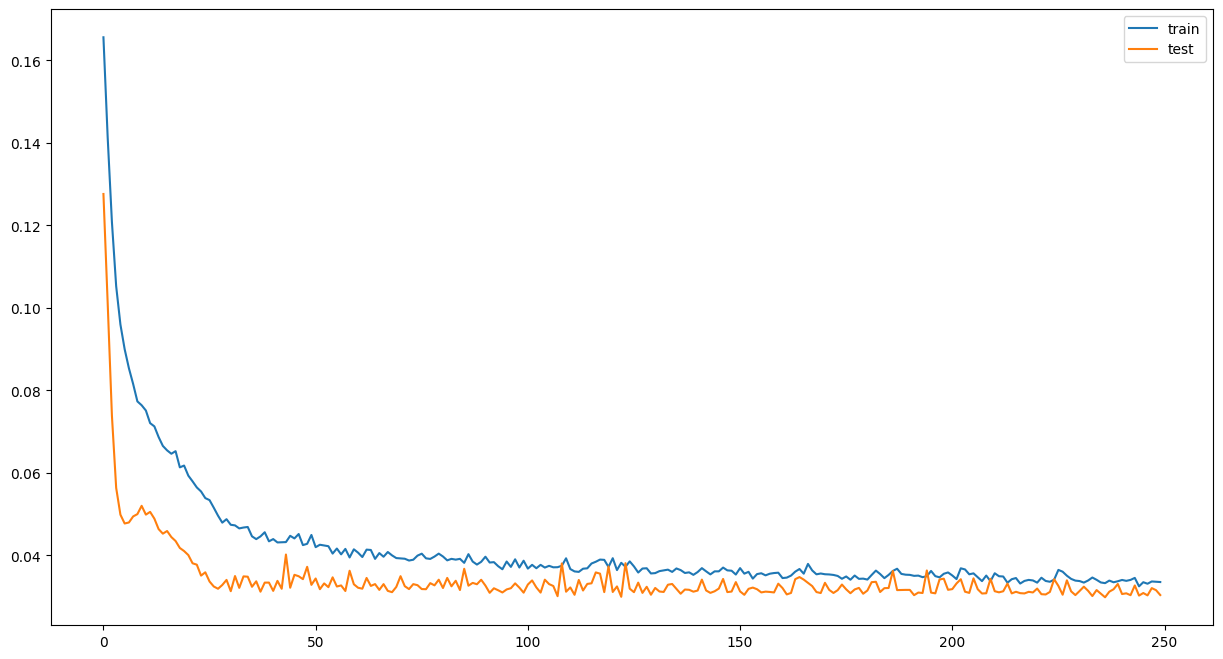

In [164]:
# plot history
plt.plot(history_8.history['loss'], label='train')
plt.plot(history_8.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [165]:
# make a prediction
pred8_y = model_Stacked_biDir_h2.predict(vec_test_X)

8/8 [==============================] - 1s 15ms/step


In [166]:
pred8_y[:5]

array([[0.0782491 , 0.07737184, 0.07836109, 0.07705124, 0.07710665],
       [0.07744877, 0.07658791, 0.07764849, 0.07645952, 0.07655137],
       [0.07675724, 0.07588439, 0.07686848, 0.07592059, 0.07596882],
       [0.07593057, 0.07515066, 0.07614744, 0.07539761, 0.07541086],
       [0.07476543, 0.07403436, 0.07500297, 0.07452646, 0.0744928 ]],
      dtype=float32)

In [167]:
pred8_y.shape

(232, 5)

## Rescaling Prediction

In [168]:
data_pred8 = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)

In [169]:
for i in range(0,5):
  data_pred8['prediction_t'+str(i+1)] = pred8_y[:,i]

In [170]:
data_pred8

,quantity,min_price,max_price,modal_price,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,...,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31,prediction_t1,prediction_t2,prediction_t3,prediction_t4,prediction_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-07-23,0.875515,0.067344,0.072551,0.081034,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,...,0.321667,0.388333,0.421667,0.388333,0.445000,0.078249,0.077372,0.078361,0.077051,0.077107
2022-07-24,0.864548,0.067344,0.081016,0.091379,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,...,0.311667,0.321667,0.388333,0.421667,0.388333,0.077449,0.076588,0.077648,0.076460,0.076551
2022-07-25,0.804913,0.067344,0.105200,0.081034,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,...,0.245000,0.311667,0.321667,0.388333,0.421667,0.076757,0.075884,0.076868,0.075921,0.075969
2022-07-26,0.854483,0.067344,0.105200,0.091379,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,...,0.145000,0.245000,0.311667,0.321667,0.388333,0.075931,0.075151,0.076147,0.075398,0.075411
2022-07-27,0.798577,0.059720,0.096735,0.091379,0.121667,0.111667,0.121667,0.111667,0.111667,0.121667,...,0.121667,0.145000,0.245000,0.311667,0.321667,0.074765,0.074034,0.075003,0.074526,0.074493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,0.085133,0.169287,0.137931,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,...,0.178333,0.166667,0.155000,0.178333,0.166667,0.131937,0.132009,0.133847,0.135028,0.133518
2023-03-10,0.060756,0.118170,0.193470,0.184483,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,...,0.200000,0.178333,0.166667,0.155000,0.178333,0.160324,0.161927,0.163803,0.164922,0.164252
2023-03-11,0.065435,0.085133,0.177751,0.172414,0.211667,0.166667,0.200000,0.188333,0.166667,0.166667,...,0.200000,0.200000,0.178333,0.166667,0.155000,0.143626,0.144405,0.146178,0.147784,0.146473


In [171]:
inv_pred8_y = scaler.inverse_transform(data_pred8)
inv_pred8_y = inv_pred8_y[:,-5:]

In [172]:
inv_pred8_y[:5,]

array([[653.84480506, 648.75664711, 654.49434519, 646.89721912,
        647.21859694],
       [649.20286834, 644.20986623, 650.36124587, 643.46521348,
        643.99794787],
       [645.19201964, 640.12948722, 645.83719522, 640.33941776,
        640.6191811 ],
       [640.39732367, 635.87383479, 641.65513515, 637.30614185,
        637.38297522],
       [633.63948762, 629.39930558, 635.01721621, 632.25346208,
        632.0582673 ]])

## Comapring Actuals vs Predicted

In [173]:
pred8_df = test_data[['quantity']]

In [174]:
for i in range(0,5):
  pred8_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred8_df['prediction_t'+str(i+1)] = inv_pred8_y[:,i]

In [175]:
pred8_df

,quantity,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,,
2022-07-23,0.875515,730.0,653.844805,670.0,648.756647,730.0,654.494345,730.0,646.897219,470.0,647.218597
2022-07-24,0.864548,670.0,649.202868,730.0,644.209866,730.0,650.361246,470.0,643.465213,530.0,643.997948
2022-07-25,0.804913,730.0,645.192020,730.0,640.129487,470.0,645.837195,530.0,640.339418,600.0,640.619181
2022-07-26,0.854483,730.0,640.397324,470.0,635.873835,530.0,641.655135,600.0,637.306142,670.0,637.382975
2022-07-27,0.798577,470.0,633.639488,530.0,629.399306,600.0,635.017216,670.0,632.253462,670.0,632.058267
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,1270.0,965.236571,1200.0,965.654358,1000.0,976.314491,930.0,983.160180,870.0,974.402559
2023-03-10,0.060756,1200.0,1129.879242,1000.0,1139.178586,930.0,1150.054872,870.0,1156.547076,930.0,1152.661675
2023-03-11,0.065435,1000.0,1033.033419,930.0,1037.547487,870.0,1047.832268,930.0,1057.145441,730.0,1049.546024


In [176]:
mean_absolute_percentage_error(inv_test_y[:,0],inv_pred8_y[:,0])

0.12920901743462682

In [177]:
# Calculate the error
error8 = pd.Series()
for i in range(0,5):
  error8['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred8_y[:,i])
print("Results of sklearn.metrics:")
print(error8)

Results of sklearn.metrics:
MAPE_1    0.129209
MAPE_2    0.156004
MAPE_3    0.175928
MAPE_4    0.192163
MAPE_5    0.205687
dtype: float64


In [178]:
model_comparision['Stacked_BiDir_LSTM_H2'] = error8
model_comparision

,LSTM,Stacked_LSTM,BiDir_LSTM,Stacked_BiDir_LSTM,Stacked_BiDir_LSTM_2,Stacked_BiDir_LSTM_3,Stacked_BiDir_LSTM_H1,Stacked_BiDir_LSTM_H2
MAPE_1,0.158445,0.178361,0.136073,0.139361,0.210002,0.135131,0.171389,0.129209
MAPE_2,0.174372,0.195842,0.160359,0.172268,0.224937,0.174448,0.178526,0.156004
MAPE_3,0.185455,0.224077,0.180898,0.189287,0.239350,0.214917,0.186562,0.175928
MAPE_4,0.204731,0.228571,0.193336,0.207456,0.264042,0.230775,0.201591,0.192163
MAPE_5,0.208217,0.239831,0.197296,0.220155,0.284243,0.241835,0.208104,0.205687


# Model 9 - Stacked Bi Directional LSTM (Hyperparameter tuning) - Increasing the number of hidden layers

## Model Building

In [179]:
# Build the Stacked Bi-Directional LSTM model
model_Stacked_biDir_h3 = Sequential()
model_Stacked_biDir_h3.add(Bidirectional(LSTM(8, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir_h3.add(Dropout(0.2))
#model_Stacked_biDir_h1.add(BatchNormalization())
model_Stacked_biDir_h3.add(Bidirectional(LSTM(8, activation='relu', return_sequences=True)))
model_Stacked_biDir_h3.add(Dropout(0.2))
#model_Stacked_biDir_h1.add(BatchNormalization())
model_Stacked_biDir_h3.add(Bidirectional(LSTM(8, activation='relu')))
model_Stacked_biDir_h3.add(Dropout(0.2))
#model_Stacked_biDir_h1.add(BatchNormalization())
model_Stacked_biDir_h3.add(Dense(vec_train_y.shape[1]))
model_Stacked_biDir_h3.compile(optimizer='adam', loss='mae')

In [180]:
model_Stacked_biDir_h3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_11 (Bidirecti  (None, 17, 16)           704       
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 17, 16)            0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 17, 16)           1600      
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 17, 16)            0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 16)               1600      
 onal)                                                           
                                                      

In [181]:
# fit network
history_9 = model_Stacked_biDir_h3.fit(vec_train_X, vec_train_y, epochs=250, batch_size=100, 
                                    validation_data=(vec_test_X, vec_test_y), verbose=1,
                                    shuffle=False)

Epoch 1/250
10/10 [==============================] - 10s 253ms/step - loss: 0.1499 - val_loss: 0.1076
Epoch 2/250
10/10 [==============================] - 1s 77ms/step - loss: 0.1217 - val_loss: 0.0767
Epoch 3/250
10/10 [==============================] - 1s 77ms/step - loss: 0.1054 - val_loss: 0.0588
Epoch 4/250
10/10 [==============================] - 1s 80ms/step - loss: 0.0972 - val_loss: 0.0533
Epoch 5/250
10/10 [==============================] - 1s 77ms/step - loss: 0.0933 - val_loss: 0.0527
Epoch 6/250
10/10 [==============================] - 0s 46ms/step - loss: 0.0898 - val_loss: 0.0529
Epoch 7/250
10/10 [==============================] - 0s 42ms/step - loss: 0.0879 - val_loss: 0.0536
Epoch 8/250
10/10 [==============================] - 0s 42ms/step - loss: 0.0855 - val_loss: 0.0543
Epoch 9/250
10/10 [==============================] - 0s 41ms/step - loss: 0.0827 - val_loss: 0.0536
Epoch 10/250
10/10 [==============================] - 0s 43ms/step - loss: 0.0816 - val_loss: 0.05

In [182]:
# fit network
#history_6 = model_Stacked_biDir3.fit(vec_train_X, vec_train_y, initial_epoch=100, epochs=200,
#                                     batch_size=32, validation_data=(vec_test_X, vec_test_y), 
#                                    verbose=2, shuffle=False)

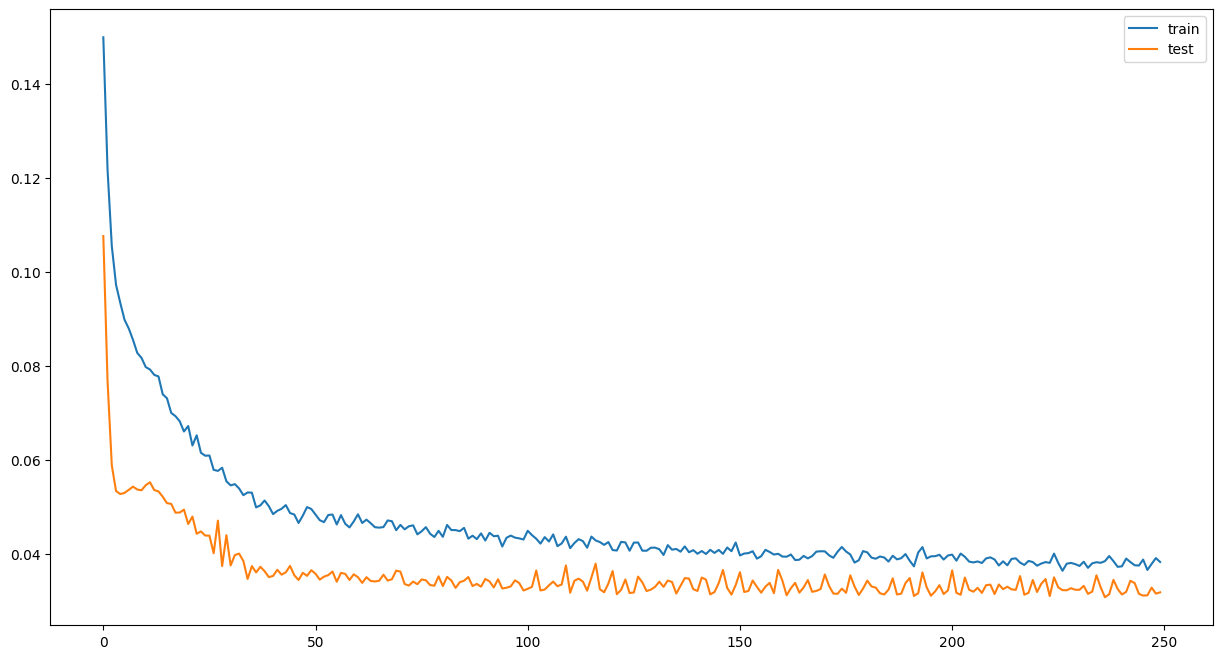

In [183]:
# plot history
plt.plot(history_9.history['loss'], label='train')
plt.plot(history_9.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [184]:
# make a prediction
pred9_y = model_Stacked_biDir_h3.predict(vec_test_X)

8/8 [==============================] - 1s 9ms/step


In [185]:
pred9_y[:5]

array([[0.06932799, 0.06685163, 0.06838318, 0.06877292, 0.06759612],
       [0.06846883, 0.06614665, 0.06795693, 0.0681967 , 0.06715415],
       [0.0678874 , 0.06560978, 0.06745348, 0.06768259, 0.06671266],
       [0.06811839, 0.06593461, 0.06801338, 0.06818683, 0.06711739],
       [0.06740709, 0.06529116, 0.06723896, 0.0675151 , 0.06642245]],
      dtype=float32)

In [186]:
pred9_y.shape

(232, 5)

## Rescaling Prediction

In [187]:
data_pred9 = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)

In [188]:
for i in range(0,5):
  data_pred9['prediction_t'+str(i+1)] = pred9_y[:,i]

In [189]:
data_pred9

,quantity,min_price,max_price,modal_price,feature_t2,feature_t3,feature_t4,feature_t5,feature_t6,feature_t7,...,feature_t27,feature_t28,feature_t29,feature_t30,feature_t31,prediction_t1,prediction_t2,prediction_t3,prediction_t4,prediction_t5
arrival_date,,,,,,,,,,,,,,,,,,,,,
2022-07-23,0.875515,0.067344,0.072551,0.081034,0.111667,0.121667,0.133333,0.133333,0.111667,0.111667,...,0.321667,0.388333,0.421667,0.388333,0.445000,0.069328,0.066852,0.068383,0.068773,0.067596
2022-07-24,0.864548,0.067344,0.081016,0.091379,0.111667,0.111667,0.121667,0.133333,0.133333,0.111667,...,0.311667,0.321667,0.388333,0.421667,0.388333,0.068469,0.066147,0.067957,0.068197,0.067154
2022-07-25,0.804913,0.067344,0.105200,0.081034,0.121667,0.111667,0.111667,0.121667,0.133333,0.133333,...,0.245000,0.311667,0.321667,0.388333,0.421667,0.067887,0.065610,0.067453,0.067683,0.066713
2022-07-26,0.854483,0.067344,0.105200,0.091379,0.111667,0.121667,0.111667,0.111667,0.121667,0.133333,...,0.145000,0.245000,0.311667,0.321667,0.388333,0.068118,0.065935,0.068013,0.068187,0.067117
2022-07-27,0.798577,0.059720,0.096735,0.091379,0.121667,0.111667,0.121667,0.111667,0.111667,0.121667,...,0.121667,0.145000,0.245000,0.311667,0.321667,0.067407,0.065291,0.067239,0.067515,0.066422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,0.085133,0.169287,0.137931,0.200000,0.188333,0.166667,0.166667,0.166667,0.200000,...,0.178333,0.166667,0.155000,0.178333,0.166667,0.132027,0.134118,0.135066,0.130780,0.137834
2023-03-10,0.060756,0.118170,0.193470,0.184483,0.166667,0.200000,0.188333,0.166667,0.166667,0.166667,...,0.200000,0.178333,0.166667,0.155000,0.178333,0.152590,0.155770,0.157829,0.153323,0.161879
2023-03-11,0.065435,0.085133,0.177751,0.172414,0.211667,0.166667,0.200000,0.188333,0.166667,0.166667,...,0.200000,0.200000,0.178333,0.166667,0.155000,0.135187,0.137634,0.138786,0.134655,0.141760


In [190]:
inv_pred9_y = scaler.inverse_transform(data_pred9)
inv_pred9_y = inv_pred9_y[:,-5:]

In [191]:
inv_pred9_y[:5,]

array([[602.10232884, 587.73945868, 596.62244171, 598.88293296,
        592.057468  ],
       [597.11922258, 583.65056664, 594.15020496, 595.54085433,
        589.49405104],
       [593.74693781, 580.5366978 , 591.23019129, 592.55904555,
        586.93344295],
       [595.08663863, 582.42075741, 594.47758943, 595.48363984,
        589.28083628],
       [590.96114486, 578.68872136, 589.9859488 , 591.58756584,
        585.25019586]])

## Comapring Actuals vs Predicted

In [192]:
pred9_df = test_data[['quantity']]

In [193]:
for i in range(0,5):
  pred9_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred9_df['prediction_t'+str(i+1)] = inv_pred9_y[:,i]

In [194]:
pred9_df

,quantity,modal_price_actual_t1,prediction_t1,modal_price_actual_t2,prediction_t2,modal_price_actual_t3,prediction_t3,modal_price_actual_t4,prediction_t4,modal_price_actual_t5,prediction_t5
arrival_date,,,,,,,,,,,
2022-07-23,0.875515,730.0,602.102329,670.0,587.739459,730.0,596.622442,730.0,598.882933,470.0,592.057468
2022-07-24,0.864548,670.0,597.119223,730.0,583.650567,730.0,594.150205,470.0,595.540854,530.0,589.494051
2022-07-25,0.804913,730.0,593.746938,730.0,580.536698,470.0,591.230191,530.0,592.559046,600.0,586.933443
2022-07-26,0.854483,730.0,595.086639,470.0,582.420757,530.0,594.477589,600.0,595.483640,670.0,589.280836
2022-07-27,0.798577,470.0,590.961145,530.0,578.688721,600.0,589.985949,670.0,591.587566,670.0,585.250196
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-09,0.045354,1270.0,965.755391,1200.0,977.884692,1000.0,983.384371,930.0,958.525190,870.0,999.439174
2023-03-10,0.060756,1200.0,1085.020569,1000.0,1103.466454,930.0,1115.406740,870.0,1089.274925,930.0,1138.895452
2023-03-11,0.065435,1000.0,984.082440,930.0,998.279846,870.0,1004.957521,930.0,980.997610,730.0,1022.207001


In [195]:
mean_absolute_percentage_error(inv_test_y[:,0],inv_pred9_y[:,0])

0.13966718630398864

In [196]:
# Calculate the error
error9 = pd.Series()
for i in range(0,5):
  error9['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred9_y[:,i])
print("Results of sklearn.metrics:")
print(error9)

Results of sklearn.metrics:
MAPE_1    0.139667
MAPE_2    0.159914
MAPE_3    0.169534
MAPE_4    0.181585
MAPE_5    0.194933
dtype: float64


In [197]:
model_comparision['Stacked_BiDir_LSTM_H3'] = error9
model_comparision

,LSTM,Stacked_LSTM,BiDir_LSTM,Stacked_BiDir_LSTM,Stacked_BiDir_LSTM_2,Stacked_BiDir_LSTM_3,Stacked_BiDir_LSTM_H1,Stacked_BiDir_LSTM_H2,Stacked_BiDir_LSTM_H3
MAPE_1,0.158445,0.178361,0.136073,0.139361,0.210002,0.135131,0.171389,0.129209,0.139667
MAPE_2,0.174372,0.195842,0.160359,0.172268,0.224937,0.174448,0.178526,0.156004,0.159914
MAPE_3,0.185455,0.224077,0.180898,0.189287,0.239350,0.214917,0.186562,0.175928,0.169534
MAPE_4,0.204731,0.228571,0.193336,0.207456,0.264042,0.230775,0.201591,0.192163,0.181585
MAPE_5,0.208217,0.239831,0.197296,0.220155,0.284243,0.241835,0.208104,0.205687,0.194933


# Comparing all models

In [198]:
model_comparision

,LSTM,Stacked_LSTM,BiDir_LSTM,Stacked_BiDir_LSTM,Stacked_BiDir_LSTM_2,Stacked_BiDir_LSTM_3,Stacked_BiDir_LSTM_H1,Stacked_BiDir_LSTM_H2,Stacked_BiDir_LSTM_H3
MAPE_1,0.158445,0.178361,0.136073,0.139361,0.210002,0.135131,0.171389,0.129209,0.139667
MAPE_2,0.174372,0.195842,0.160359,0.172268,0.224937,0.174448,0.178526,0.156004,0.159914
MAPE_3,0.185455,0.224077,0.180898,0.189287,0.239350,0.214917,0.186562,0.175928,0.169534
MAPE_4,0.204731,0.228571,0.193336,0.207456,0.264042,0.230775,0.201591,0.192163,0.181585
MAPE_5,0.208217,0.239831,0.197296,0.220155,0.284243,0.241835,0.208104,0.205687,0.194933


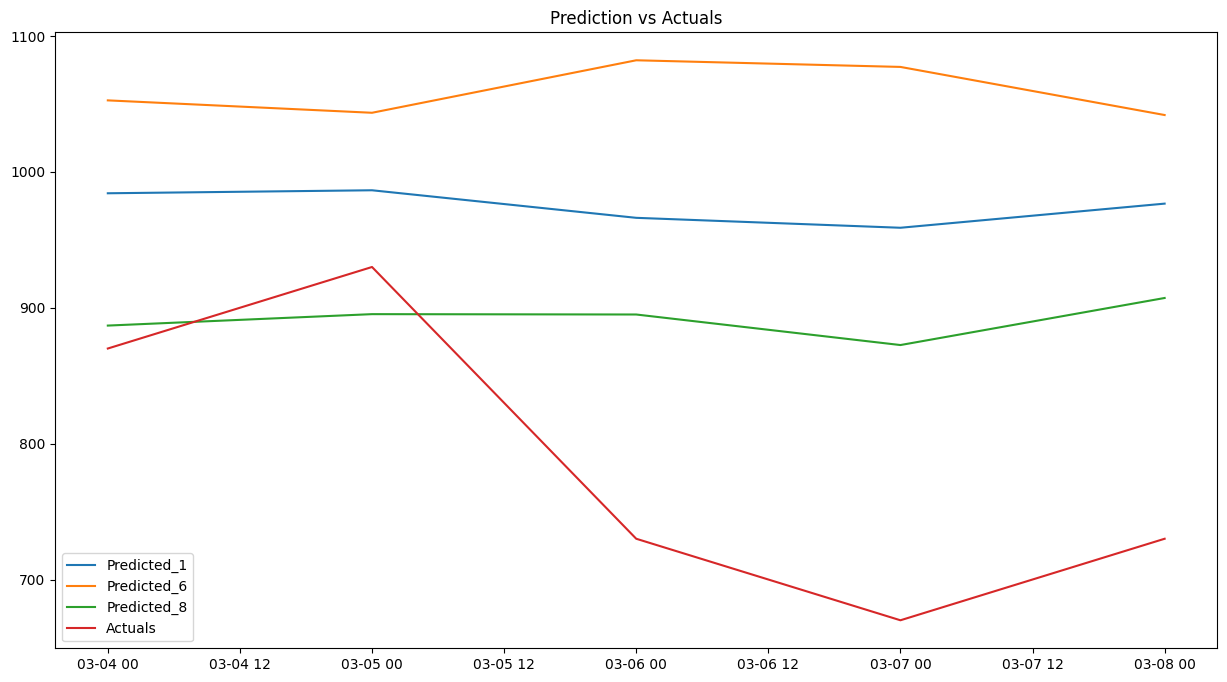

In [199]:
y_pred_1 = inv_pred_y[-1].reshape(inv_pred_y.shape[1])
y_pred_6 = inv_pred6_y[-1].reshape(inv_pred6_y.shape[1])
y_pred_9 = inv_pred9_y[-1].reshape(inv_pred9_y.shape[1])
y_actual = inv_test_y[-1].reshape(inv_test_y.shape[1])
x = pred_df.index[-10:-5]
plt.plot(x, y_pred_1, label='Predicted_1')
plt.plot(x, y_pred_6, label='Predicted_6')
plt.plot(x, y_pred_9, label='Predicted_8')
plt.plot(x, y_actual, label='Actuals')
plt.legend()
plt.title('Prediction vs Actuals')
plt.show()

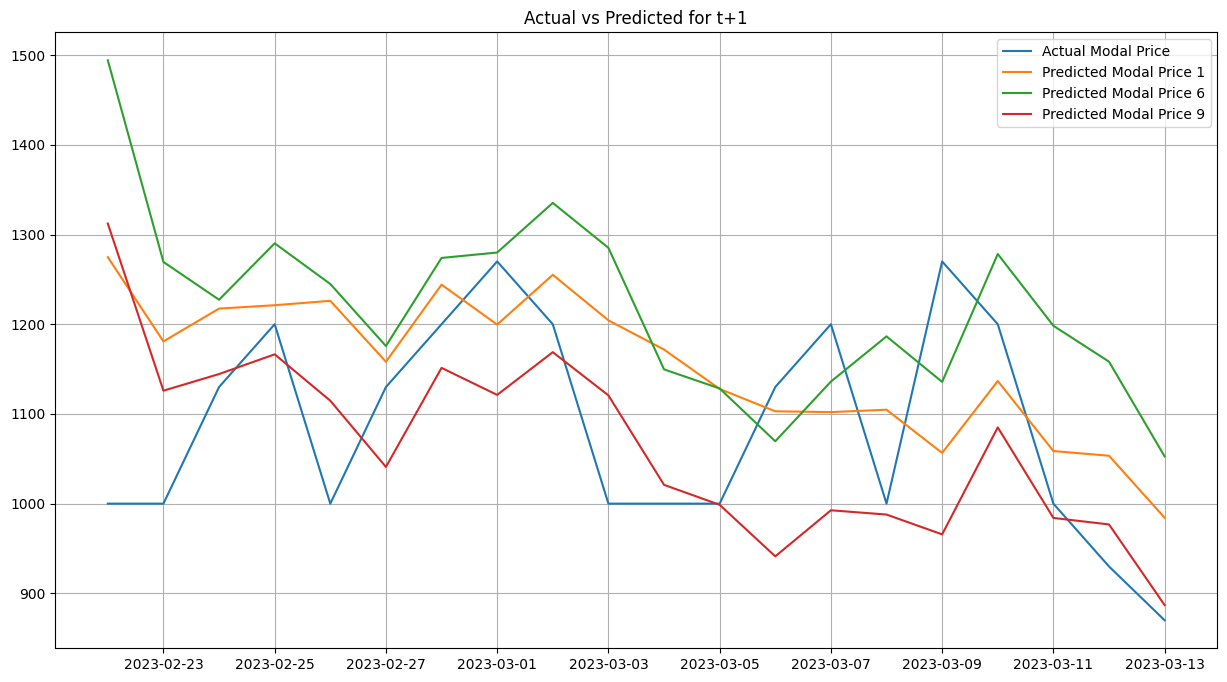

In [200]:
plt.plot(pred_df['modal_price_actual_t1'][-20:], label='Actual Modal Price')
plt.plot(pred_df['prediction_t1'][-20:],  label='Predicted Modal Price 1')
plt.plot(pred6_df['prediction_t1'][-20:],  label='Predicted Modal Price 6')
#plt.plot(pred8_df['prediction_t1'][-20:],  label='Predicted Modal Price 8')
plt.plot(pred9_df['prediction_t1'][-20:],  label='Predicted Modal Price 9')
plt.legend()
plt.grid()
plt.title('Actual vs Predicted for t+1')
plt.show()

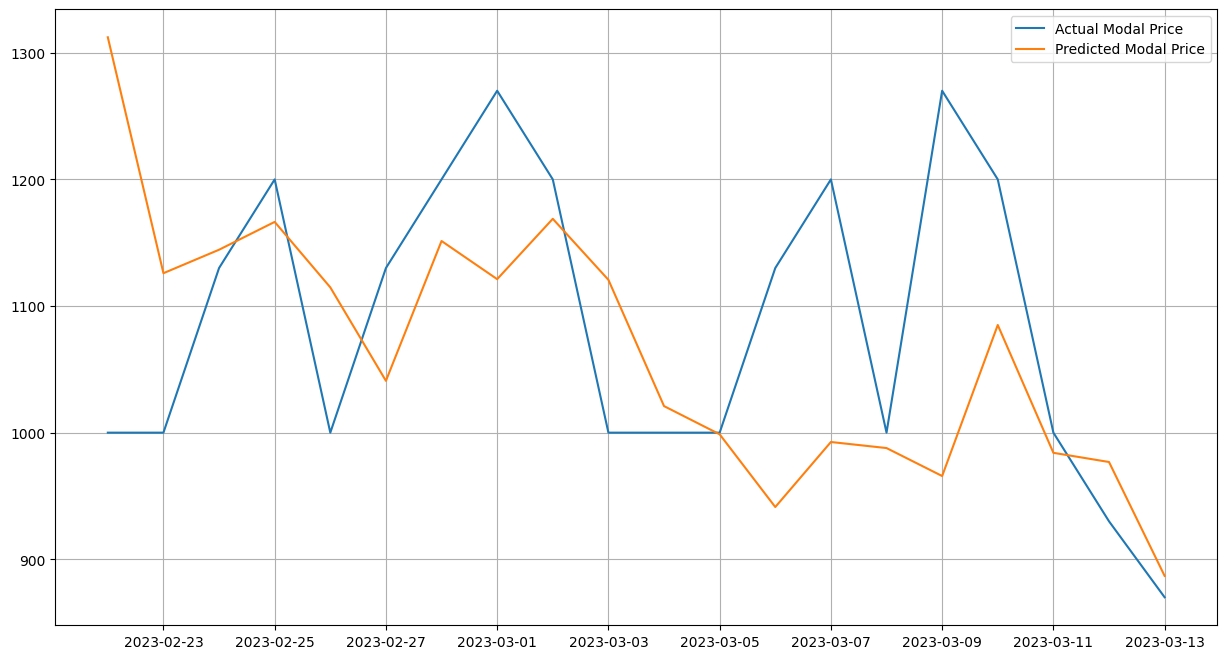

In [201]:
plt.plot(pred9_df['modal_price_actual_t1'][-20:], label='Actual Modal Price')
plt.plot(pred9_df['prediction_t1'][-20:],  label='Predicted Modal Price')
plt.legend()
plt.grid()
#plt.title('Actual vs Predicted for t+1')
plt.show()

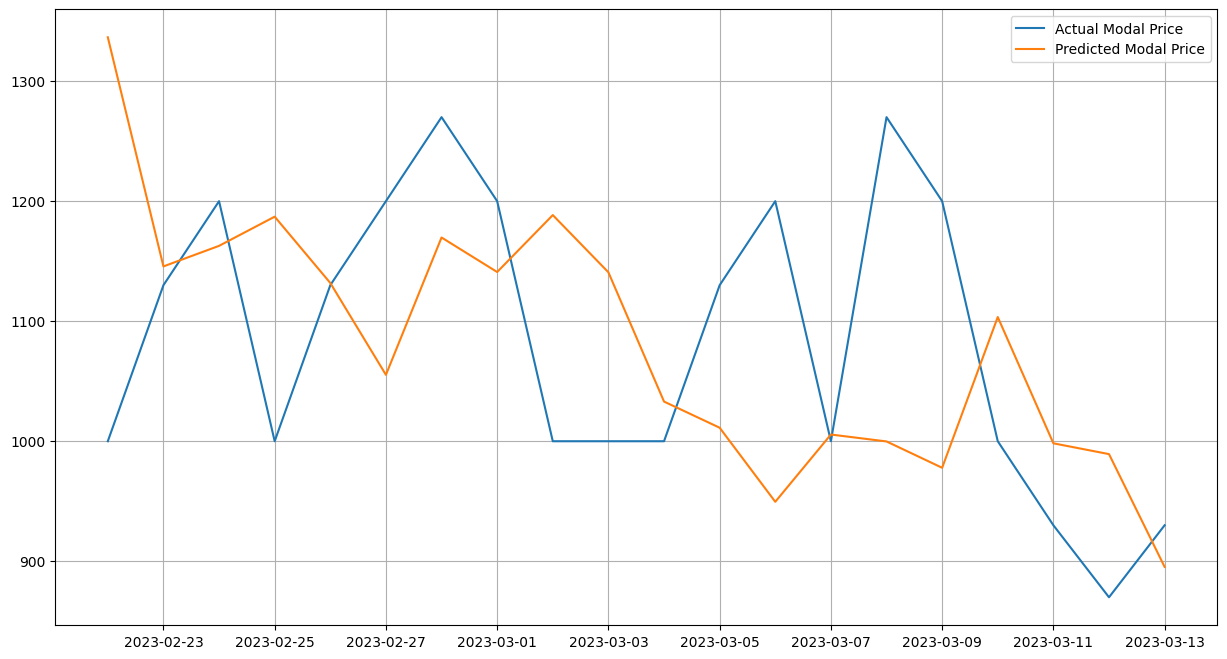

In [202]:
plt.plot(pred9_df['modal_price_actual_t2'][-20:], label='Actual Modal Price')
plt.plot(pred9_df['prediction_t2'][-20:],  label='Predicted Modal Price')
plt.legend()
plt.grid()
#plt.title('Actual vs Predicted for t+2')
plt.show()

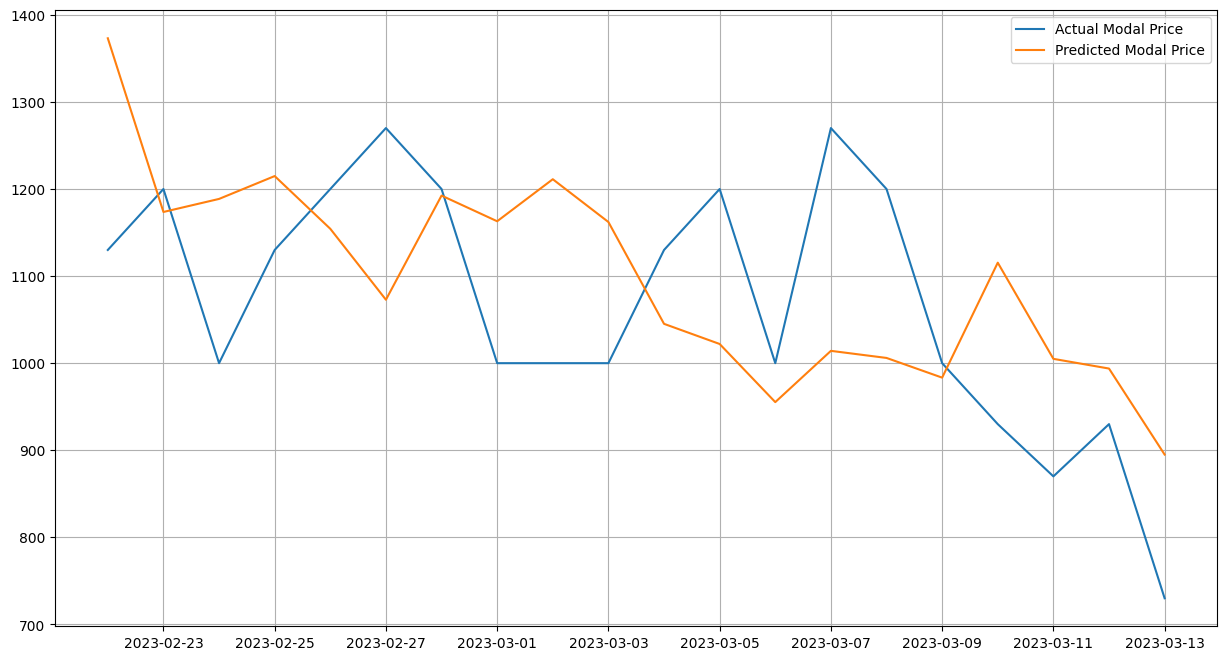

In [203]:
plt.plot(pred9_df['modal_price_actual_t3'][-20:], label='Actual Modal Price')
plt.plot(pred9_df['prediction_t3'][-20:],  label='Predicted Modal Price')
plt.legend()
plt.grid()
#plt.title('Actual vs Predicted for t+3')
plt.show()

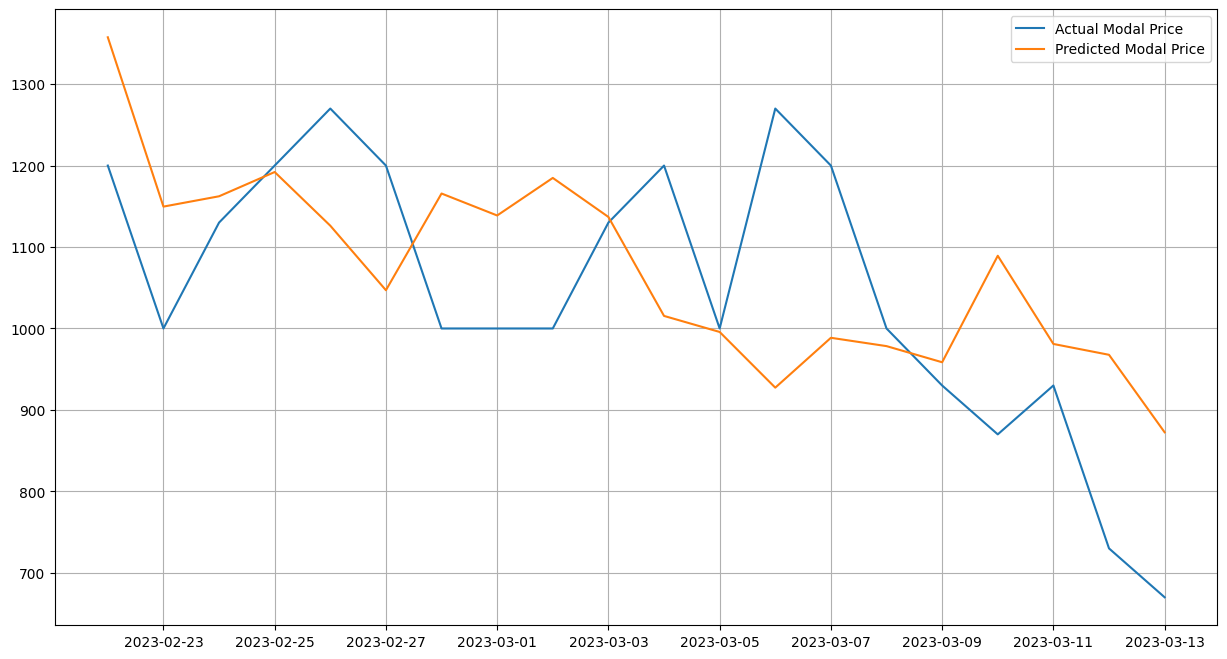

In [204]:
plt.plot(pred9_df['modal_price_actual_t4'][-20:], label='Actual Modal Price')
plt.plot(pred9_df['prediction_t4'][-20:],  label='Predicted Modal Price')
plt.legend()
plt.grid()
#plt.title('Actual vs Predicted for t+4')
plt.show()

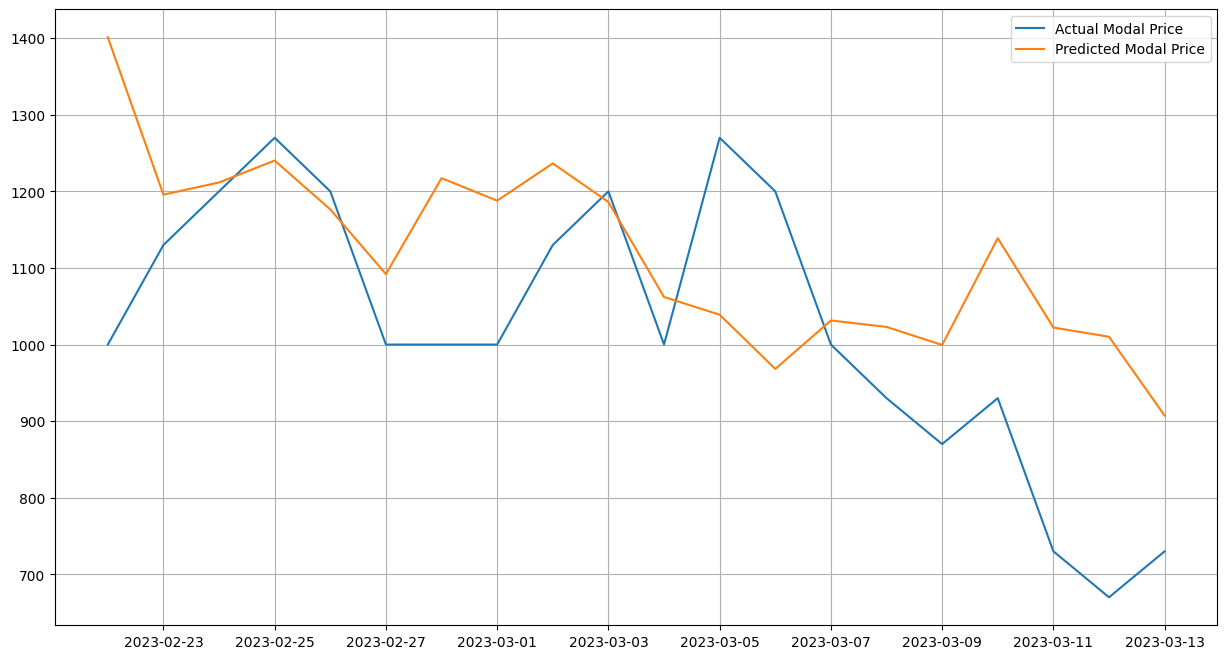

In [205]:
plt.plot(pred9_df['modal_price_actual_t5'][-20:], label='Actual Modal Price')
plt.plot(pred9_df['prediction_t5'][-20:],  label='Predicted Modal Price')
plt.legend()
plt.grid()
#plt.title('Actual vs Predicted for t+5')
plt.show()

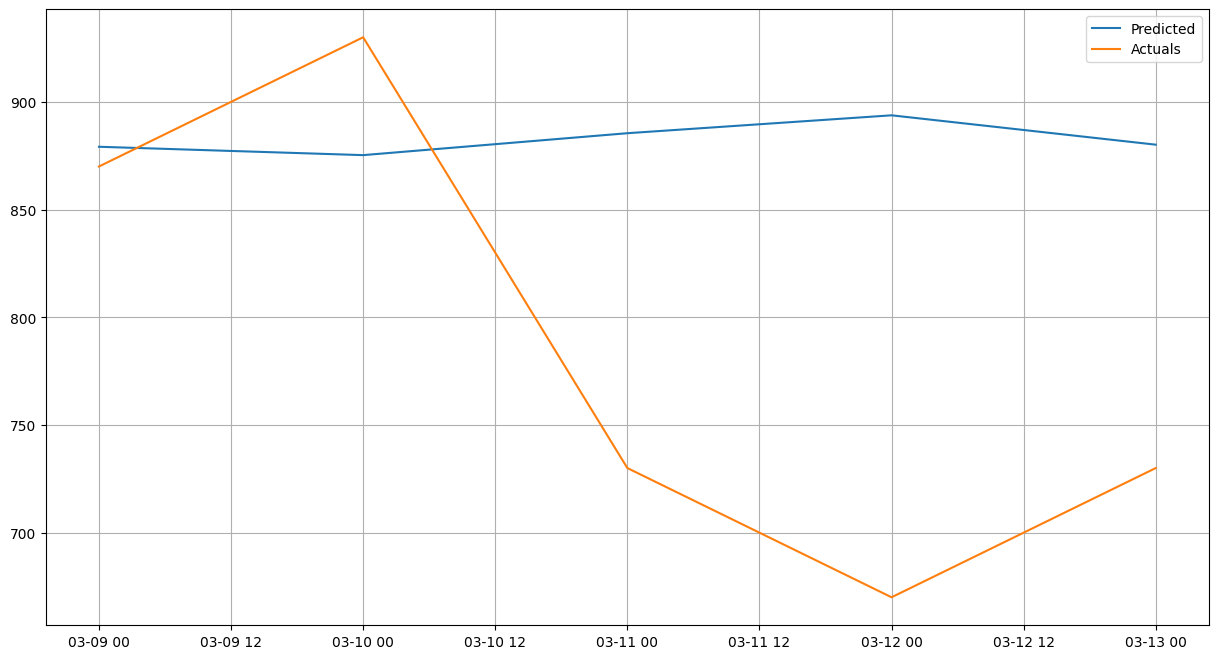

In [206]:
#y_pred = inv_pred_y[-1:].reshape(inv_pred_y.shape[1])
#y_pred_6 = inv_pred6_y[-2:-1].reshape(inv_pred6_y.shape[1])
y_pred_8 = inv_pred8_y[-1:].reshape(inv_pred8_y.shape[1])
y_actual = inv_test_y[-1:].reshape(inv_test_y.shape[1])
x = pred_df.index[-5:]
#plt.plot(x, y_pred, label='Predicted_1')
#plt.plot(x, y_pred_6, label='Predicted_6')
plt.plot(x, y_pred_8, label='Predicted')
plt.plot(x, y_actual, label='Actuals')
plt.legend()
plt.grid()
#plt.title('Prediction vs Actuals')
plt.show()

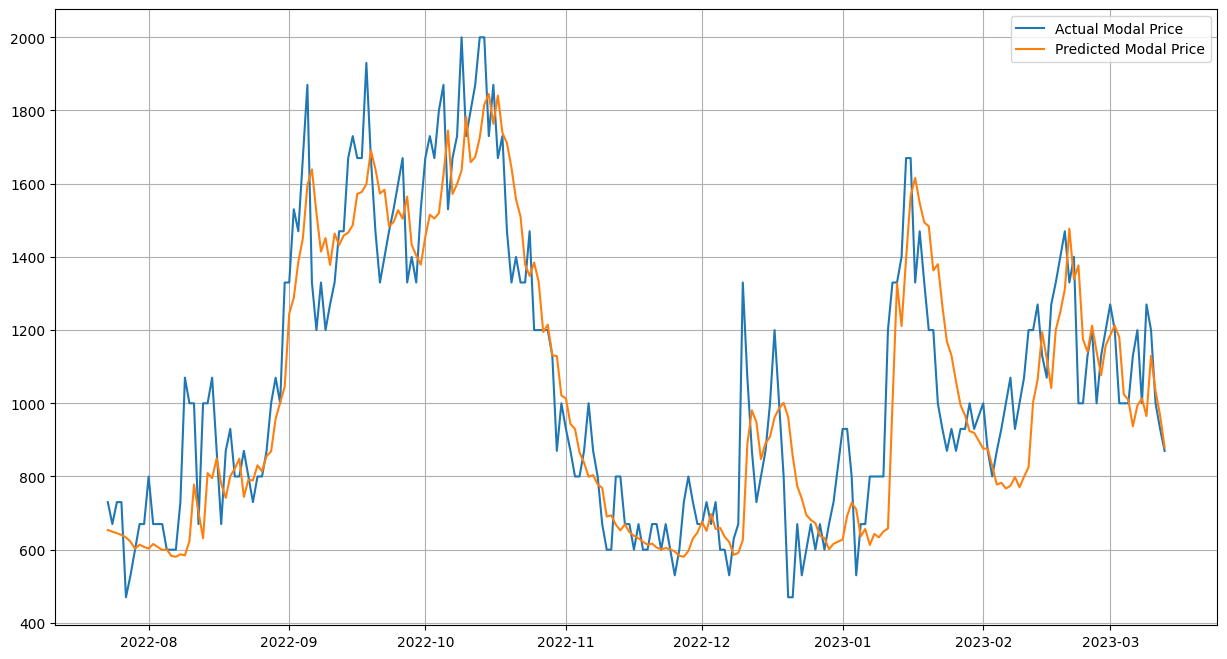

In [207]:
plt.plot(pred8_df['modal_price_actual_t1'], label='Actual Modal Price')
plt.plot(pred8_df['prediction_t1'],  label='Predicted Modal Price')
#plt.plot(pred9_df['prediction_t2'][-20:],  label='Predicted Modal Price 2')
#plt.plot(pred9_df['prediction_t3'][-20:],  label='Predicted Modal Price 3')
#plt.plot(pred9_df['prediction_t4'][-20:],  label='Predicted Modal Price 4')
#plt.plot(pred9_df['prediction_t5'][-20:],  label='Predicted Modal Price 5')
plt.legend()
plt.grid()
#plt.title('Predicted t+1 to t+5')
plt.show()